<a href="https://colab.research.google.com/github/Sania-git/UIDAI-Aadhaar-Enrollment-Analysis/blob/main/UIDAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rapidfuzz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
from rapidfuzz import process, fuzz


In [ ]:
import csv
import pandas as pd

with open("/content/api_data_aadhar_enrolment_0_500000.csv", "r", errors="ignore") as f:
    sample = f.read(10000)
    dialect = csv.Sniffer().sniff(sample)
    delimiter = dialect.delimiter

enroll_raw = pd.read_csv(
    "/content/api_data_aadhar_enrolment_0_500000.csv",
    sep=delimiter,
    engine="python",
    encoding="utf-8",
    quoting=csv.QUOTE_MINIMAL,
    on_bad_lines="skip"   # THIS is the key
)

print("Rows:", enroll_raw.shape[0])


district_master = pd.read_excel("/content/Districts.xlsx")
# 3. Immediate sanity checks
print("Total rows:", len(enroll_raw))
print(
    "Missing district (%):",
    round(enroll_raw['district'].isna().mean() * 100, 2)
)


Rows: 1030161
Total rows: 1030161
Missing district (%): 0.0


In [ ]:
district_master

,State,District
0,Andaman Nicobar,Nicobar
1,Andaman Nicobar,North Middle Andaman
2,Andaman Nicobar,South Andaman
3,Andhra Pradesh,Alluri Sitarama Raju
4,Andhra Pradesh,Anakapalli
...,...,...
782,West Bengal,Purba Bardhaman
783,West Bengal,Purba Medinipur
784,West Bengal,Purulia
785,West Bengal,South 24 Parganas


In [ ]:
enroll_raw

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-25,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-25,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-25,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-25,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-25,Karnataka,Bengaluru Urban,560016,14,16,21
...,...,...,...,...,...,...,...
1030156,31-12-25,West Bengal,West Midnapore,721149,2,0,0
1030157,31-12-25,West Bengal,West Midnapore,721150,2,2,0
1030158,31-12-25,West Bengal,West Midnapore,721305,0,1,0
1030159,31-12-25,West Bengal,West Midnapore,721504,1,0,0


# DATA VALIDATION

In [ ]:
#  ROW VALIDITY

import pandas as pd
import numpy as np

df = enroll_raw.copy()

# ---- basic checks ----
valid_date = pd.to_datetime(df["date"], errors="coerce").notna()
valid_state = df["state"].notna()
valid_district = df["district"].notna()

valid_pincode = (
    df["pincode"]
    .astype(str)
    .str.match(r"^\d{6}$", na=False)
)

valid_ages = (
    df[["age_0_5", "age_5_17", "age_18_greater"]]
    .notna()
    .all(axis=1)
    &
    (df[["age_0_5", "age_5_17", "age_18_greater"]] >= 0).all(axis=1)
)

non_zero_enrollment = (
    df[["age_0_5", "age_5_17", "age_18_greater"]].sum(axis=1) > 0
)

# ---- master validity flag ----
df["is_valid"] = (
    valid_date &
    valid_state &
    valid_district &
    valid_pincode &
    valid_ages &
    non_zero_enrollment
)

print(df["is_valid"].value_counts())


/tmp/ipython-input-328447027.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  valid_date = pd.to_datetime(df["date"], errors="coerce").notna()


is_valid
True     1030160
False          1
Name: count, dtype: int64


In [ ]:
# WHY ROWS INVALID

invalid = df[~df["is_valid"]]

diagnostics = {
    "Invalid date": (~valid_date).sum(),
    "Missing state": (~valid_state).sum(),
    "Missing district": (~valid_district).sum(),
    "Invalid pincode": (~valid_pincode).sum(),
    "Invalid ages": (~valid_ages).sum(),
    "Zero enrollment": (~non_zero_enrollment).sum(),
}

pd.Series(diagnostics)


,0
Invalid date,1
Missing state,0
Missing district,0
Invalid pincode,0
Invalid ages,0
Zero enrollment,0


In [ ]:
enroll_valid = df[df["is_valid"]].copy()
print("Final valid rows:", enroll_valid.shape[0])


Final valid rows: 1030160


In [ ]:
assert enroll_valid.isna().sum().sum() == 0
assert enroll_valid["pincode"].astype(str).str.match(r"^\d{6}$").all()
assert (enroll_valid[["age_0_5", "age_5_17", "age_18_greater"]] >= 0).all().all()

print("✅ DATA VALIDATION PASSED")


✅ DATA VALIDATION PASSED


In [ ]:
# Keep only valid rows
enroll_final = enroll_valid.drop(columns=["is_valid"]).copy()

# Optional: reorder (clean presentation)
enroll_final = enroll_final[
    [
        "date",
        "state",
        "district",
        "pincode",
        "age_0_5",
        "age_5_17",
        "age_18_greater"
    ]
]

enroll_final.head()


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-25,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-25,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-25,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-25,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-25,Karnataka,Bengaluru Urban,560016,14,16,21


In [ ]:
enroll_final

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-25,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-25,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-25,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-25,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-25,Karnataka,Bengaluru Urban,560016,14,16,21
...,...,...,...,...,...,...,...
1030156,31-12-25,West Bengal,West Midnapore,721149,2,0,0
1030157,31-12-25,West Bengal,West Midnapore,721150,2,2,0
1030158,31-12-25,West Bengal,West Midnapore,721305,0,1,0
1030159,31-12-25,West Bengal,West Midnapore,721504,1,0,0


# STATE CLEANING

In [ ]:
# STATE CLEANING

In [ ]:
enroll_final['state'].unique()

array(['Meghalaya', 'Karnataka', 'Uttar Pradesh', 'Bihar', 'Maharashtra',
       'Haryana', 'Rajasthan', 'Punjab', 'Delhi', 'Madhya Pradesh',
       'West Bengal', 'Assam', 'Uttarakhand', 'Gujarat', 'Andhra Pradesh',
       'Tamil Nadu', 'Chhattisgarh', 'Jharkhand', 'Nagaland', 'Manipur',
       'Telangana', 'Tripura', 'Mizoram', 'Jammu and Kashmir',
       'Chandigarh', 'Sikkim', 'Odisha', 'Kerala',
       'The Dadra And Nagar Haveli And Daman And Diu',
       'Arunachal Pradesh', 'Himachal Pradesh', 'Goa',
       'Jammu And Kashmir', 'Dadra and Nagar Haveli and Daman and Diu',
       'Ladakh', 'Andaman and Nicobar Islands', 'Orissa', 'Pondicherry',
       'Puducherry', 'Lakshadweep', 'Andaman & Nicobar Islands',
       'Dadra & Nagar Haveli', 'Dadra and Nagar Haveli', 'Daman and Diu',
       'WEST BENGAL', 'Jammu & Kashmir', 'West  Bengal', 'Daman & Diu',
       'West Bangal', 'Westbengal', 'West bengal', 'andhra pradesh',
       'ODISHA', 'WESTBENGAL'], dtype=object)

State Cleaning cases fall into 5 clear buckets:

1. Case issues (WEST BENGAL, andhra pradesh)

2. Extra spaces (West Bengal)

3. Spelling variants (West Bangal, Westbengal)

4. Old / alternate names (Orissa, Pondicherry)

5. Merger / split UT variants (Dadra…, Daman & Diu, Jammu & Kashmir)

We’ll handle this with a canonical mapping

In [ ]:
# DEFINE OFFICIAL STATE LIST

official_states = {
    "Andhra Pradesh",
    "Arunachal Pradesh",
    "Assam",
    "Bihar",
    "Chhattisgarh",
    "Goa",
    "Gujarat",
    "Haryana",
    "Himachal Pradesh",
    "Jharkhand",
    "Karnataka",
    "Kerala",
    "Madhya Pradesh",
    "Maharashtra",
    "Manipur",
    "Meghalaya",
    "Mizoram",
    "Nagaland",
    "Odisha",
    "Punjab",
    "Rajasthan",
    "Sikkim",
    "Tamil Nadu",
    "Telangana",
    "Tripura",
    "Uttar Pradesh",
    "Uttarakhand",
    "West Bengal",
    "Delhi",
    "Chandigarh",
    "Jammu and Kashmir",
    "Ladakh",
    "Lakshadweep",
    "Puducherry",
    "Andaman and Nicobar Islands",
    "Dadra and Nagar Haveli and Daman and Diu"
}


In [ ]:
# NORMALIZE TEXT
import re
import pandas as pd

def normalize_state(x):
    if pd.isna(x):
        return x
    x = x.strip().lower()
    x = re.sub(r"\s+", " ", x)
    x = x.replace("&", "and")
    return x


In [ ]:
# EXPLICITLY STATE VARIATIONS

state_mapping = {
    # West Bengal variants
    "west bengal": "West Bengal",
    "west  bengal": "West Bengal",
    "westbengal": "West Bengal",
    "west bangal": "West Bengal",
    "west bengal ": "West Bengal",

    # Odisha / Orissa
    "orissa": "Odisha",
    "odisha": "Odisha",

    # Andhra Pradesh
    "andhra pradesh": "Andhra Pradesh",

    # Jammu & Kashmir
    "jammu and kashmir": "Jammu and Kashmir",
    "jammu and kashmir": "Jammu and Kashmir",
    "jammu and kashmir": "Jammu and Kashmir",
    "jammu & kashmir": "Jammu and Kashmir",

    # Puducherry
    "pondicherry": "Puducherry",

    # Andaman & Nicobar
    "andaman and nicobar islands": "Andaman and Nicobar Islands",
    "andaman and nicobar islands": "Andaman and Nicobar Islands",

    # Dadra / Daman merger
    "dadra and nagar haveli": "Dadra and Nagar Haveli and Daman and Diu",
    "daman and diu": "Dadra and Nagar Haveli and Daman and Diu",
    "dadra and nagar haveli and daman and diu":
        "Dadra and Nagar Haveli and Daman and Diu",
    "the dadra and nagar haveli and daman and diu":
        "Dadra and Nagar Haveli and Daman and Diu"
}


In [ ]:
enroll = enroll_final.copy()

In [ ]:
# APPLY CLEANING

# Preserve raw
enroll["state_raw"] = enroll["state"]

# Normalize
enroll["state_norm"] = enroll["state_raw"].apply(normalize_state)

# Map
enroll["state_cleaned"] = enroll["state_norm"].map(state_mapping)

# Fallback: title case if already valid
enroll["state_final"] = enroll["state_cleaned"].fillna(
    enroll["state_raw"].str.strip().str.title()
)


In [ ]:
invalid_states = set(enroll["state_final"].unique()) - official_states

print("❌ Invalid states remaining:", invalid_states)


❌ Invalid states remaining: set()


In [ ]:
enroll = enroll.drop(columns=["state", "state_norm", "state_cleaned"])
enroll = enroll.rename(columns={"state_final": "state"})


In [ ]:
enroll['state'].unique()

array(['Meghalaya', 'Karnataka', 'Uttar Pradesh', 'Bihar', 'Maharashtra',
       'Haryana', 'Rajasthan', 'Punjab', 'Delhi', 'Madhya Pradesh',
       'West Bengal', 'Assam', 'Uttarakhand', 'Gujarat', 'Andhra Pradesh',
       'Tamil Nadu', 'Chhattisgarh', 'Jharkhand', 'Nagaland', 'Manipur',
       'Telangana', 'Tripura', 'Mizoram', 'Jammu and Kashmir',
       'Chandigarh', 'Sikkim', 'Odisha', 'Kerala',
       'Dadra and Nagar Haveli and Daman and Diu', 'Arunachal Pradesh',
       'Himachal Pradesh', 'Goa', 'Ladakh', 'Andaman and Nicobar Islands',
       'Puducherry', 'Lakshadweep'], dtype=object)

In [ ]:
enroll['state'].nunique()

36

# DISTRICT CLEANING

In [ ]:
enroll['district'].unique()

array(['Baksa', 'Barpeta', 'Biswanath', 'Bongaigaon', 'Cachar',
       'Charaideo', 'Chirang', 'Darrang', 'Dhemaji', 'Dhubri',
       'Dibrugarh', 'Dima Hasao', 'Goalpara', 'Golaghat', 'Hailakandi',
       'Hojai', 'Jorhat', 'Kamrup', 'Kamrup Metro', 'Karbi Anglong',
       'Karimganj', 'Kokrajhar', 'Lakhimpur', 'Marigaon', 'Nagaon',
       'Nalbari', 'Sivasagar', 'Sonitpur', 'South Salmara Mankachar',
       'Tinsukia', 'Udalguri', 'West Karbi Anglong', 'Bhagalpur',
       'East Champaran', 'Gaya', 'Jamui', 'Jehanabad', 'Kaimur',
       'Madhubani', 'Munger', 'Muzaffarpur', 'Patna', 'Purnia', 'Saran',
       'Sitamarhi', 'Vaishali', 'West Champaran', 'Chandigarh', 'Durg',
       'Raipur', 'Sukma', 'Vijayapura', 'Central Delhi', 'East Delhi',
       'North East Delhi', 'North West Delhi', 'South Delhi',
       'South West Delhi', 'West Delhi', 'Ahmedabad', 'Amreli', 'Anand',
       'Banaskantha', 'Bharuch', 'Bhavnagar', 'Botad', 'Chhotaudepur',
       'Dahod', 'Devbhumi Dwarka', 'Gandh

India has 750+ districts, and our list contains:

1. spelling variants (West Medinipur vs Paschim Medinipur)

2. old names (Allahabad, Faizabad)

3. new names (Prayagraj, Ayodhya)

4. merged/split districts

5. admin suffixes (*, (BH), (KAR))

6. short forms (S.A.S Nagar)

7. casing junk (HOOGHLY, nadia)

8. punctuation junk (Medchal?malkajgiri)

9. state codes inside district names (Bijapur(KAR))



In [ ]:
enroll = enroll.copy()

In [ ]:
# 1. preserve raw district

enroll["district_raw"] = enroll["district"]


In [ ]:
# 2.  Safe normalization function
import re
import pandas as pd

def normalize_district(x):
    if pd.isna(x):
        return x

    x = x.lower().strip()

    # remove brackets and their content
    x = re.sub(r"\(.*?\)", "", x)

    # remove stars and special chars
    x = re.sub(r"[*?]", "", x)

    # normalize spaces
    x = re.sub(r"\s+", " ", x)

    return x


In [ ]:
district_master['District'].unique()

In [ ]:
# ============================================================
# FINAL DISTRICT CLEANING PIPELINE (CANONICAL + SAFE)
# ============================================================

import pandas as pd
import numpy as np
import re

# ------------------------------------------------------------
# 0. SAFETY: work on a copy
# ------------------------------------------------------------
enroll = enroll.copy()
district_master = district_master.copy()

# ------------------------------------------------------------
# 1. FREEZE RAW COLUMNS (NEVER TOUCH AGAIN)
# ------------------------------------------------------------
enroll["district_raw"] = enroll["district"]

district_master["district_raw"] = district_master["District"]

# ------------------------------------------------------------
# 2. LIGHT NORMALIZATION (NO FUZZY, NO INVENTION)
# ------------------------------------------------------------
def normalize_light(x):
    if pd.isna(x):
        return np.nan
    x = str(x).lower()
    x = re.sub(r"\(.*?\)", "", x)     # remove brackets
    x = re.sub(r"&", "and", x)
    x = re.sub(r"[^a-z\s]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

enroll["district_norm"] = enroll["district_raw"].apply(normalize_light)
district_master["district_norm"] = district_master["district_raw"].apply(normalize_light)

# ------------------------------------------------------------
# 3. BUILD CANONICAL DISTRICT UNIVERSE (THE KEY STEP)
# ------------------------------------------------------------
canonical_districts = pd.concat(
    [
        enroll[["district_norm"]],
        district_master[["district_norm"]],
    ],
    ignore_index=True
).drop_duplicates()

# ------------------------------------------------------------
# 4. CREATE STANDARD REPRESENTATION (SAFE TITLE CASE)
# ------------------------------------------------------------
canonical_districts["district_std"] = canonical_districts["district_norm"].str.title()

# ------------------------------------------------------------
# 5. MAP BACK TO ENROLL (ZERO ROW LOSS GUARANTEED)
# ------------------------------------------------------------
enroll = enroll.merge(
    canonical_districts,
    on="district_norm",
    how="left",
    validate="m:1"
)

# ------------------------------------------------------------
# 6. FINAL DISTRICT (HONEST, TRACEABLE)
# ------------------------------------------------------------
enroll["district_final"] = enroll["district_std"]

# ------------------------------------------------------------
# 7. CLEAN OUTPUT (KEEP RAW FOR AUDIT)
# ------------------------------------------------------------
enroll = enroll.drop(columns=["district", "district_norm", "district_std"])
enroll = enroll.rename(columns={"district_final": "district"})

# ------------------------------------------------------------
# 8. HARD VALIDATION (MUST BE ZERO)
# ------------------------------------------------------------
print("Rows:", len(enroll))
print("Null districts:", enroll["district"].isna().sum())
print("Duplicate rows:", enroll.duplicated().sum())


In [ ]:
# ============================================================
# FINAL DATASET PIPELINE (CLEAN + REORDERED)
# ============================================================

import pandas as pd
import re

# ------------------------------------------------------------
# 0. SAFETY COPY
# ------------------------------------------------------------
df = enroll.copy()

# ------------------------------------------------------------
# 1. REMOVE EXACT DUPLICATE ROWS
# ------------------------------------------------------------
before = len(df)
df = df.drop_duplicates()
print(f"Exact duplicate rows removed: {before - len(df)}")

# ------------------------------------------------------------
# 2. LIGHT NORMALIZATION FUNCTION
# ------------------------------------------------------------
def normalize_light(x):
    if pd.isna(x):
        return x
    x = x.lower().strip()
    x = re.sub(r"\(.*?\)", "", x)
    x = re.sub(r"[*]", "", x)
    x = re.sub(r"[&]", "and", x)
    x = re.sub(r"\s+", " ", x)
    return x

# ------------------------------------------------------------
# 3. NORMALIZE ENROLL DATA
# ------------------------------------------------------------
df["_state_norm"] = df["state"].apply(normalize_light)
df["_district_norm"] = df["district"].apply(normalize_light)

# ------------------------------------------------------------
# 4. NORMALIZE DISTRICT MASTER
# ------------------------------------------------------------
dm = district_master.copy()
dm["_state_norm"] = dm["State"].apply(normalize_light)
dm["_district_norm"] = dm["District"].apply(normalize_light)

# ------------------------------------------------------------
# 5. CREATE CANONICAL ADMIN UNIVERSE
# ------------------------------------------------------------
canonical = pd.concat([
    df[["_state_norm", "_district_norm"]],
    dm[["_state_norm", "_district_norm"]]
]).drop_duplicates().reset_index(drop=True)

canonical["_state_clean"] = canonical["_state_norm"].str.title()
canonical["_district_clean"] = canonical["_district_norm"].str.title()

# ------------------------------------------------------------
# 6. MAP CLEAN VALUES BACK
# ------------------------------------------------------------
df = df.merge(
    canonical,
    on=["_state_norm", "_district_norm"],
    how="left"
)

# ------------------------------------------------------------
# 7. DROP RAW STATE & DISTRICT
# ------------------------------------------------------------
df = df.drop(columns=["state", "district"])

# ------------------------------------------------------------
# 8. RENAME CLEAN COLUMNS AS FINAL
# ------------------------------------------------------------
df = df.rename(columns={
    "_state_clean": "state",
    "_district_clean": "district"
})

# ------------------------------------------------------------
# 9. DROP TEMP NORMALIZATION COLUMNS
# ------------------------------------------------------------
df = df.drop(columns=["_state_norm", "_district_norm"])

# ------------------------------------------------------------
# 10. REORDER COLUMNS (STATE, DISTRICT TO FRONT)
# ------------------------------------------------------------
cols = df.columns.tolist()
cols.remove("state")
cols.remove("district")

final_cols = ["state", "district"] + cols
df = df[final_cols]

# ------------------------------------------------------------
# 11. FINAL VALIDATION
# ------------------------------------------------------------
print("\nFINAL VALIDATION")
print("----------------")
print("Rows:", len(df))
print("Null state:", df["state"].isna().sum())
print("Null district:", df["district"].isna().sum())
print("Duplicate rows:", df.duplicated().sum())

# ------------------------------------------------------------
# 12. FINAL OUTPUT
# ------------------------------------------------------------
enroll_clean = df


In [ ]:
enroll_clean

In [ ]:
# ============================================================
# FINAL ENROLL DATASET — CLEAN & ORDERED
# ============================================================

# Work on cleaned dataframe
df = enroll_clean.copy()

# ------------------------------------------------------------
# 1. DROP ANY LEFTOVER RAW / TEMP COLUMNS (SAFE DROP)
# ------------------------------------------------------------
cols_to_drop = [
    "state_raw", "district_raw",
    "state_norm", "district_norm",
    "_state_norm", "_district_norm",
    "state_clean", "district_clean",
    "state_matched", "state_std",
    "is_valid"
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# ------------------------------------------------------------
# 2. FINAL COLUMN ORDER (ADMIN + ANALYSIS READY)
# ------------------------------------------------------------
final_column_order = [
    "date",
    "state",
    "district",
    "pincode",
    "age_0_5",
    "age_5_17",
    "age_18_greater"
]

df = df[final_column_order]

# ------------------------------------------------------------
# 3. FINAL VALIDATION
# ------------------------------------------------------------
print("FINAL ENROLL DATASET")
print("--------------------")
print("Rows:", len(df))
print("Null state:", df["state"].isna().sum())
print("Null district:", df["district"].isna().sum())
print("Duplicate rows:", df.duplicated().sum())
print("\nColumns:", df.columns.tolist())

# ------------------------------------------------------------
# 4. ASSIGN FINAL OUTPUT
# ------------------------------------------------------------
enroll_final = df


In [ ]:
enroll_final

In [ ]:
enroll_final['district'].unique()

In [ ]:
# solving further district related issues

# ============================================================
# FINAL DISTRICT RESOLUTION PIPELINE (SAFE + DEFENSIBLE)
# ============================================================

import pandas as pd
import re

df = enroll_final.copy()

# ------------------------------------------------------------
# 1. Normalize district lightly (NO information loss)
# ------------------------------------------------------------
def normalize_district(x):
    if pd.isna(x):
        return x
    x = x.strip()
    x = re.sub(r"\s+", " ", x)
    return x

df["district"] = df["district"].apply(normalize_district)

# ------------------------------------------------------------
# 2. Controlled alias mapping (historical / spelling variants)
#    ONLY widely accepted renames
# ------------------------------------------------------------
district_alias_map = {
    # UP
    "Allahabad": "Prayagraj",
    "Faizabad": "Ayodhya",
    "Raebareli": "Rae Bareli",
    "Bulandshahar": "Bulandshahr",
    "Samstipur": "Samastipur",

    # Karnataka
    "Bangalore": "Bengaluru",
    "Bangalore Rural": "Bengaluru Rural",
    "Bangalore Urban": "Bengaluru Urban",
    "Belgaum": "Belagavi",
    "Bellary": "Ballari",
    "Gulbarga": "Kalaburagi",
    "Mysore": "Mysuru",
    "Shimoga": "Shivamogga",
    "Tumkur": "Tumakuru",

    # Tamil Nadu
    "Tuticorin": "Thoothukkudi",
    "Kancheepuram": "Kanchipuram",
    "Viluppuram": "Villupuram",

    # Gujarat
    "Ahmadabad": "Ahmedabad",
    "Ahmed Nagar": "Ahmednagar",
    "Sabar Kantha": "Sabarkantha",
    "Surendra Nagar": "Surendranagar",
    "Panch Mahals": "Panchmahals",

    # West Bengal
    "Hooghiy": "Hooghly",
    "Hawrah": "Howrah",
    "Burdwan": "Bardhaman",
    "Koch Bihar": "Cooch Behar",
    "Medinipur": "Paschim Medinipur",

    # Telangana / AP
    "Mahabub Nagar": "Mahbubnagar",
    "Karim Nagar": "Karimnagar",
    "Rangareddy": "Ranga Reddy",

    # Jammu & Kashmir
    "Badgam": "Budgam",
    "Baramula": "Baramulla",
    "Shupiyan": "Shopian",

    # Uttarakhand
    "Hardwar": "Haridwar"
}

df["district"] = df["district"].replace(district_alias_map)

# ------------------------------------------------------------
# 3. Flag structurally invalid districts (DO NOT DELETE)
# ------------------------------------------------------------
invalid_patterns = [
    r"^(north|south|east|west)$",
    r"lakshadweep",
    r"andamans?",
    r"nicobars?",
]

df["district_confidence"] = "HIGH"
df.loc[
    df["district"].str.lower().str.strip().str.match("|".join(invalid_patterns)),
    "district_confidence"
] = "LOW"

# ------------------------------------------------------------
# 4. Final sanity checks
# ------------------------------------------------------------
print("Rows:", len(df))
print("Null districts:", df["district"].isna().sum())
print("Low-confidence districts:", (df["district_confidence"] == "LOW").sum())
print("Unique districts:", df["district"].nunique())

# ------------------------------------------------------------
# 5. Assign final dataset
# ------------------------------------------------------------
enroll_final = df.copy()


In [ ]:
enroll_final['district'].unique()

In [ ]:
import pandas as pd
import numpy as np
import re

# -------------------- AUTO-DETECT DISTRICT COLUMN --------------------
DISTRICT_COL = (
    "district_final" if "district_final" in df.columns else
    "district" if "district" in df.columns else
    None
)

STATE_COL = (
    "state_final" if "state_final" in df.columns else
    "state" if "state" in df.columns else
    None
)

if DISTRICT_COL is None or STATE_COL is None:
    raise ValueError("District or State column not found")

# -------------------- CONFIG --------------------
INVALID_DISTRICTS = {
    "east", "west", "north", "south", "north east",
    "unknown", "na", "n/a", "none", ""
}

DISTRICT_CANONICAL_MAP = {
    "bara banki": "Barabanki",
    "shrawasti": "Shravasti",
    "jyotiba phule nagar": "Amroha",
    "sant ravidas nagar bhadohi": "Bhadohi",

    "purbi champaran": "East Champaran",
    "pashchim champaran": "West Champaran",
    "purnea": "Purnia",
    "monghyr": "Munger",

    "coochbehar": "Cooch Behar",
    "barddhaman": "Bardhaman",
    "haora": "Howrah",
    "darjiling": "Darjeeling",
    "puruliya": "Purulia",

    "gurgaon": "Gurugram",
    "mewat": "Nuh",

    "rangareddi": "Ranga Reddy",
    "k v rangareddy": "Ranga Reddy",

    "ysr": "Y S R",
    "ys r": "Y S R",

    "kodarma": "Koderma",
    "hazaribag": "Hazaribagh",

    "anugul": "Angul",
    "baleshwar": "Balasore",
    "sonapur": "Subarnapur",

    "kasargod": "Kasaragod",
    "kanyakumari": "Kanniyakumari",

    "chamrajnagar": "Chamarajanagar",
    "chamrajanagar": "Chamarajanagar",
    "chikmagalur": "Chikkamagaluru",

    "kabeerdham": "Kawardha",
    "uttar bastar kanker": "Kanker"
}

# -------------------- NORMALIZATION FUNCTION --------------------
def normalize_district(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().lower()
    x = re.sub(r"\s+", " ", x)
    if x in INVALID_DISTRICTS:
        return np.nan
    return DISTRICT_CANONICAL_MAP.get(x, x.title())

# -------------------- APPLY CLEANING --------------------
df["district_clean"] = df[DISTRICT_COL].apply(normalize_district)

df = df.dropna(subset=["district_clean"])

# -------------------- STATE–DISTRICT VALIDATION --------------------
pair_counts = (
    df.groupby([STATE_COL, "district_clean"])
      .size()
      .reset_index(name="count")
)

VALID_PAIRS = pair_counts[pair_counts["count"] >= 5][
    [STATE_COL, "district_clean"]
]

df = df.merge(
    VALID_PAIRS,
    on=[STATE_COL, "district_clean"],
    how="inner"
)

# -------------------- FINALIZE COLUMNS --------------------
df = df.rename(columns={"district_clean": "district_final"})

RAW_COLS = [
    "raw_state", "raw_district",
    "district_norm", "district_confidence"
]

df = df.drop(columns=[c for c in RAW_COLS if c in df.columns], errors="ignore")

FINAL_ORDER = [STATE_COL, "district_final"]
OTHER_COLS = [c for c in df.columns if c not in FINAL_ORDER]

df = df[FINAL_ORDER + OTHER_COLS]

# -------------------- VALIDATION OUTPUT --------------------
print("Rows:", len(df))
print("Null districts:", df["district_final"].isna().sum())
print("Unique districts:", df["district_final"].nunique())
print("Unique states:", df[STATE_COL].nunique())


In [ ]:
df["district_final"].unique()

In [ ]:
import pandas as pd
import re

# ================================
# 0. SAFETY COPY
# ================================
enroll = enroll.copy()

# ================================
# 1. NORMALIZATION FUNCTION
# ================================
def normalize(x):
    if pd.isna(x):
        return x
    x = str(x).lower().strip()
    x = re.sub(r"\(.*?\)", "", x)
    x = re.sub(r"&", "and", x)
    x = re.sub(r"[^a-z\s]", "", x)
    x = re.sub(r"\s+", " ", x)
    return x

enroll["state_norm"] = enroll["state"].apply(normalize)
enroll["district_norm"] = enroll["district"].apply(normalize)

# ================================
# 2. CANONICAL 2025 STATE MAP
# ================================
STATE_MAP = {
    "andaman and nicobar islands": "Andaman and Nicobar Islands",
    "andaman nicobar": "Andaman and Nicobar Islands",
    "jammu and kashmir": "Jammu and Kashmir",
    "jammu kashmir": "Jammu and Kashmir",
    "dadra and nagar haveli and daman and diu": "Dadra and Nagar Haveli and Daman and Diu",
    "orissa": "Odisha",
    "pondicherry": "Puducherry",
    "west bengal": "West Bengal",
}

enroll["state_clean"] = enroll["state_norm"].map(STATE_MAP).fillna(
    enroll["state_norm"].str.title()
)

# ================================
# 3. CANONICAL 2025 DISTRICT MAP
# ================================
DISTRICT_MAP = {
    # Uttar Pradesh
    ("uttar pradesh", "allahabad"): "Prayagraj",

    # Odisha
    ("odisha", "orissa"): None,

    # Maharashtra
    ("maharashtra", "ahmednagar"): "Ahilyanagar",
    ("maharashtra", "osmanabad"): "Dharashiv",
    ("maharashtra", "bid"): "Beed",

    # Jammu & Kashmir
    ("jammu and kashmir", "leh"): "Leh",
    ("jammu and kashmir", "kargil"): "Kargil",

    # Andaman & Nicobar
    ("andaman and nicobar islands", "andaman and nicobar"): "South Andaman",
}

def resolve_district(row):
    key = (row["state_norm"], row["district_norm"])
    if key in DISTRICT_MAP and DISTRICT_MAP[key]:
        return DISTRICT_MAP[key]
    return row["district_norm"].title()

enroll["district_clean"] = enroll.apply(resolve_district, axis=1)

# ================================
# 4. VALIDATION FLAGS
# ================================
enroll["district_valid"] = ~enroll["district_clean"].isna()

# ================================
# 5. DROP RAW / NORM COLS
# ================================
enroll_final = enroll.drop(
    columns=["state_norm", "district_norm", "district_valid"]
)

# ================================
# 6. REORDER FINAL COLUMNS
# ================================
enroll_final = enroll_final[
    [
        "date",
        "state_clean",
        "district_clean",
        "pincode",
        "age_0_5",
        "age_5_17",
        "age_18_greater",
    ]
].rename(
    columns={
        "state_clean": "state",
        "district_clean": "district"
    }
)

# ================================
# 7. FINAL SANITY CHECK
# ================================
print("Rows:", len(enroll_final))
print("Null states:", enroll_final["state"].isna().sum())
print("Null districts:", enroll_final["district"].isna().sum())
print("Unique states:", enroll_final["state"].nunique())
print("Unique districts:", enroll_final["district"].nunique())


In [ ]:
enroll_final["district"].value_counts().head(20)


In [ ]:
district_conflicts = (
    enroll_final
    .groupby(["state", "pincode"])["district"]
    .nunique()
    .reset_index(name="district_variants")
    .query("district_variants > 1")
)


In [ ]:
canonical_district = (
    enroll_final
    .groupby(["state", "pincode", "district"])
    .size()
    .reset_index(name="count")
    .sort_values(["state", "pincode", "count"], ascending=[True, True, False])
    .drop_duplicates(["state", "pincode"])
)


In [ ]:
df_final['district'].unique()

In [ ]:
# ================= FINAL CANONICAL DISTRICT ENFORCEMENT =================
# Assumes df already loaded
# REQUIRED columns: ['state', 'district', 'pincode', ...]
# OUTPUT: df with CLEAN district + state, raw columns removed

import pandas as pd
import re

# ------------------------------------------------------------------
# 1. SAFETY: lock base columns
# ------------------------------------------------------------------
df = df.copy()
df['state'] = df['state'].astype(str).str.strip().str.title()
df['district'] = df['district'].astype(str).str.strip()

# ------------------------------------------------------------------
# 2. NORMALIZATION (internal only, not final names)
# ------------------------------------------------------------------
def normalize(text):
    text = text.lower().strip()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

df['state_norm'] = df['state'].apply(normalize)
df['district_norm'] = df['district'].apply(normalize)

# ------------------------------------------------------------------
# 3. CANONICAL DISTRICT MAP (VERIFIED ONLY)
# ------------------------------------------------------------------
CANONICAL_DISTRICT_MAP = {

    # Telangana / Andhra Pradesh
    'rangareddi': 'Ranga Reddy',
    'k v rangareddy': 'Ranga Reddy',
    'rangareddy': 'Ranga Reddy',
    'mahbubnagar': 'Mahabubnagar',
    'ananthapur': 'Ananthapuramu',
    'ananthapuramu': 'Ananthapuramu',
    'cuddapah': 'Ysr Kadapa',
    'ysr': 'Ysr Kadapa',
    'ysr kadapa': 'Ysr Kadapa',

    # Karnataka
    'hasan': 'Hassan',
    'chickmagalur': 'Chikkamagaluru',
    'chikmagalur': 'Chikkamagaluru',
    'bellary': 'Ballari',
    'bijapur': 'Vijayapura',
    'tumkur': 'Tumakuru',
    'belgaum': 'Belagavi',
    'shimoga': 'Shivamogga',

    # West Bengal
    'haora': 'Howrah',
    'barddhaman': 'Purba Bardhaman',
    'bardhaman': 'Purba Bardhaman',
    'east midnapore': 'Purba Medinipur',
    'west midnapore': 'Paschim Medinipur',
    'darjiling': 'Darjeeling',

    # Odisha
    'baudh': 'Boudh',
    'sonapur': 'Subarnapur',
    'khorda': 'Khordha',

    # Maharashtra
    'ahmadnagar': 'Ahmednagar',

    # Punjab
    'sas nagar': 'Sahibzada Ajit Singh Nagar',
    'nawanshahr': 'Shaheed Bhagat Singh Nagar',

    # Haryana / UP
    'gurgaon': 'Gurugram',
    'bara banki': 'Barabanki',

    # Assam / NE
    'north cachar hills': 'Dima Hasao',
    'mammit': 'Mamit',
    'rib hoi': 'Ribhoi',

    # Tamil Nadu
    'kanniyakumari': 'Kanyakumari',
    'kancheepuram': 'Kanchipuram',
    'viluppuram': 'Viluppuram',

    # Madhya Pradesh
    'hoshangabad': 'Narmadapuram',
    'east nimar': 'Khandwa',

    # Gujarat
    'kachchh': 'Kutch',

    # J&K
    'punch': 'Poonch',
}

# ------------------------------------------------------------------
# 4. APPLY CANONICAL MAP (NO FUZZY MATCHING)
# ------------------------------------------------------------------
df['district_canonical'] = (
    df['district_norm']
    .map(CANONICAL_DISTRICT_MAP)
    .fillna(df['district'].str.title())
)

# ------------------------------------------------------------------
# 5. PINCODE + STATE SAFETY CONSOLIDATION
# Only collapse variants when BOTH match
# ------------------------------------------------------------------
df['district_final'] = (
    df.groupby(['state_norm', 'pincode'])['district_canonical']
      .transform(lambda x: x.mode().iloc[0])
)

# ------------------------------------------------------------------
# 6. FINAL CLEANUP
# ------------------------------------------------------------------
df_final = df.drop(
    columns=[
        'district',
        'district_norm',
        'district_canonical',
        'state_norm'
    ]
)

df_final = df_final.rename(columns={'district_final': 'district'})

# Column order (clean + analysis ready)
priority = ['date', 'state', 'district', 'pincode']
others = [c for c in df_final.columns if c not in priority]
df_final = df_final[priority + others]

# ------------------------------------------------------------------
# 7. FINAL VALIDATION (MUST READ)
# ------------------------------------------------------------------
print("FINAL DATASET STATUS")
print("Rows:", len(df_final))
print("Null states:", df_final['state'].isna().sum())
print("Null districts:", df_final['district'].isna().sum())
print("Unique states:", df_final['state'].nunique())
print("Unique districts:", df_final['district'].nunique())

# Optional inspection
# print(df_final['district'].value_counts().head(20))


In [ ]:
df_final['district'].unique()

In [ ]:
import pandas as pd
import re

# ===============================
# 1. BASIC NORMALIZATION (IN-PLACE)
# ===============================
def normalize_text(x):
    x = str(x).strip()
    x = re.sub(r'\s+', ' ', x)   # collapse multiple spaces
    x = x.title()                # standard casing
    return x

df['district'] = df['district'].apply(normalize_text)

# ===============================
# 2. HARD CANONICAL MERGE MAP (2025)
# ===============================
CANONICAL_DISTRICT_MAP = {

    # Andhra Pradesh
    "Nellore": "Sri Potti Sriramulu Nellore",
    "Ysr Kadapa": "YSR Kadapa",
    "N T R": "NTR",

    # Jharkhand
    "Purbi Singhbhum": "East Singhbhum",

    # Odisha
    "Sundergarh": "Sundargarh",

    # Telangana
    "Rangareddy": "Ranga Reddy",

    # West Bengal
    "Darjiling": "Darjeeling",

    # Uttar Pradesh
    "Bara Banki": "Barabanki",

    # Bihar / Jharkhand legacy drift
    "Hazaribag": "Hazaribagh"
}

df['district'] = df['district'].replace(CANONICAL_DISTRICT_MAP)

# ===============================
# 3. FINAL SANITY NORMALIZATION
# ===============================
df['district'] = (
    df['district']
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)

# ===============================
# 4. HARD ASSERTIONS (FAIL FAST)
# ===============================

# 4.1 No nulls allowed
assert df['district'].isna().sum() == 0, "❌ Null districts remain"

# 4.2 Forbidden legacy names must NOT exist
FORBIDDEN = {
    "Nellore",
    "Purbi Singhbhum",
    "Sundergarh",
    "Ysr Kadapa",
    "N T R",
    "Rangareddy",
    "Darjiling",
    "Bara Banki",
    "Hazaribag"
}

bad_leftovers = set(df['district']) & FORBIDDEN
assert len(bad_leftovers) == 0, f"❌ Forbidden districts still present: {bad_leftovers}"

# ===============================
# 5. FINAL OUTPUT
# ===============================
final_districts = sorted(df['district'].unique())

print("✅ FINAL CLEAN DISTRICT COUNT:", len(final_districts))
print("✅ SAMPLE DISTRICTS:", final_districts[:20])


In [ ]:
# ==========================================================
# FINAL HARD CANONICAL DISTRICT COLLAPSE (2025 AUTHORITATIVE)
# ==========================================================

CANONICAL_FIX = {

    # ---------------- TELANGANA ----------------
    "K V Rangareddy": "Ranga Reddy",
    "Rangareddi": "Ranga Reddy",
    "Rangareddy": "Ranga Reddy",

    # ---------------- KARNATAKA ----------------
    "Hasan": "Hassan",
    "Chickmagalur": "Chikkamagaluru",
    "Chikmagalur": "Chikkamagaluru",

    # ---------------- WEST BENGAL ----------------
    "Barddhaman": "Purba Bardhaman",
    "Haora": "Howrah",
    "West Midnapore": "Paschim Medinipur",
    "East Midnapore": "Purba Medinipur",

    # ---------------- ODISHA ----------------
    "Baudh": "Boudh",
    "Sonapur": "Subarnapur",
    "Khorda": "Khordha",
    "Sundergarh": "Sundargarh",

    # ---------------- ANDHRA PRADESH ----------------
    "Anantapur": "Ananthapuramu",
    "Ananthapur": "Ananthapuramu",
    "Ysr": "YSR Kadapa",
    "Ysr Kadapa": "YSR Kadapa",

    # ---------------- MADHYA PRADESH (2025) ----------------
    "Hoshangabad": "Narmadapuram",
    "East Nimar": "Khandwa",
}

df["district"] = df["district"].replace(CANONICAL_FIX)

# ---------------- FINAL ASSERTION ----------------
FORBIDDEN_LEFTOVERS = {
    "K V Rangareddy", "Rangareddi", "Hasan", "Chickmagalur", "Chikmagalur",
    "Barddhaman", "Haora", "West Midnapore", "East Midnapore",
    "Baudh", "Sonapur", "Khorda", "Sundergarh",
    "Anantapur", "Ananthapur", "Ysr", "Ysr Kadapa",
    "Hoshangabad", "East Nimar"
}

bad = set(df["district"]) & FORBIDDEN_LEFTOVERS
assert not bad, f"❌ Canonical leak still present: {bad}"

print("✅ FINAL DISTRICT CANONICALIZATION COMPLETE")
print("✅ Unique districts:", df["district"].nunique())


In [ ]:
OPTIONAL_LGD_PATCH = {
    "Gurgaon": "Gurugram",
    "Ahmadnagar": "Ahmednagar"
}

df["district"] = df["district"].replace(OPTIONAL_LGD_PATCH)


In [ ]:
import re

# ======================================================
# FINAL DISTRICT CLEANING — PRODUCTION FREEZE
# ======================================================

def normalize_district(x):
    x = str(x).strip()
    x = re.sub(r'\s+', ' ', x)
    return x.title()

df['district'] = df['district'].apply(normalize_district)

# ------------------------------------------------------
# FINAL SAFE CANONICAL MAP (STATE-AGNOSTIC, VERIFIED)
# ------------------------------------------------------
CANONICAL_DISTRICT_MAP = {

    # WEST BENGAL
    "North Parganas": "North Twenty Four Parganas",
    "South Parganas": "South Twenty Four Parganas",
    "Haora": "Howrah",
    "West Midnapore": "Paschim Medinipur",
    "East Midnapore": "Purba Medinipur",
    "Barddhaman": "Purba Bardhaman",

    # TELANGANA / AP
    "Rangareddi": "Ranga Reddy",
    "K V Rangareddy": "Ranga Reddy",
    "Ananthapur": "Anantapuramu",
    "Anantapur": "Anantapuramu",

    # KARNATAKA
    "Hasan": "Hassan",
    "Chikmagalur": "Chikkamagaluru",

    # ODISHA
    "Jajapur": "Jajpur",
    "Baudh": "Boudh",
    "Khorda": "Khordha",
    "Sonapur": "Subarnapur",

    # TAMIL NADU / PUDUCHERRY
    "Kanyakumari": "Kanniyakumari",
    "Pondicherry": "Puducherry",

    # MIZORAM
    "Mammit": "Mamit",

    # RAJASTHAN
    "Chittaurgarh": "Chittorgarh",

    # ACRONYMS
    "Ntr": "NTR"
}

df['district'] = df['district'].replace(CANONICAL_DISTRICT_MAP)

# ------------------------------------------------------
# FINAL ASSERTIONS — MUST PASS
# ------------------------------------------------------
FORBIDDEN = {
    "North Parganas",
    "South Parganas",
    "Haora",
    "West Midnapore",
    "East Midnapore",
    "Barddhaman",
    "Rangareddi",
    "K V Rangareddy",
    "Hasan",
    "Mammit",
    "Pondicherry",
    "Jajapur",
    "Baudh",
    "Khorda",
    "Sonapur",
    "Chittaurgarh",
    "Ntr"
}

bad = set(df['district'].unique()).intersection(FORBIDDEN)
assert not bad, f"❌ Unresolved district drift remains: {bad}"

print("✅ FINAL DISTRICT LIST CLEANED & FROZEN")
print("Unique districts:", df['district'].nunique())


In [ ]:
import re

# ======================================================
# FINAL DISTRICT CANONICALIZATION — ABSOLUTE FINAL
# ======================================================

def normalize(x):
    x = str(x).strip()
    x = re.sub(r'\s+', ' ', x)
    return x.title()

df['district'] = df['district'].apply(normalize)

CANONICAL_DISTRICT_MAP = {

    # ---------------- WEST BENGAL ----------------
    "North Parganas": "North Twenty Four Parganas",
    "South Parganas": "South Twenty Four Parganas",
    "Barddhaman": "Purba Bardhaman",
    "Haora": "Howrah",
    "West Midnapore": "Paschim Medinipur",
    "East Midnapore": "Purba Medinipur",

    # ---------------- TELANGANA / ANDHRA ----------------
    "Rangareddi": "Ranga Reddy",
    "K V Rangareddy": "Ranga Reddy",
    "Anantapur": "Anantapuramu",
    "Ananthapur": "Anantapuramu",

    # ---------------- KARNATAKA ----------------
    "Hasan": "Hassan",
    "Chikmagalur": "Chikkamagaluru",

    # ---------------- ODISHA ----------------
    "Baudh": "Boudh",
    "Jajapur": "Jajpur",
    "Sonapur": "Subarnapur",
    "Khorda": "Khordha",

    # ---------------- TN / UT ----------------
    "Kanyakumari": "Kanniyakumari",
    "Pondicherry": "Puducherry",

    # ---------------- MIZORAM ----------------
    "Mammit": "Mamit",

    # ---------------- RAJASTHAN ----------------
    "Chittaurgarh": "Chittorgarh"
}

df['district'] = df['district'].replace(CANONICAL_DISTRICT_MAP)

# ======================================================
# HARD FAIL IF ANY BAD VARIANT SURVIVES
# ======================================================

FORBIDDEN = {
    "North Parganas", "South Parganas", "Barddhaman", "Haora",
    "West Midnapore", "East Midnapore",
    "Rangareddi", "K V Rangareddy",
    "Hasan", "Chikmagalur",
    "Baudh", "Jajapur", "Sonapur", "Khorda",
    "Kanyakumari", "Pondicherry",
    "Mammit", "Chittaurgarh"
}

leftover = set(df['district'].unique()) & FORBIDDEN
assert not leftover, f"❌ STILL DIRTY DISTRICTS FOUND: {leftover}"

print("✅ DISTRICT CANONICALIZATION COMPLETE")
print("Final unique districts:", df['district'].nunique())


In [ ]:
df["district"].unique()

In [ ]:
import pandas as pd
import re

# ------------------------------------------------------------
# 1. CANONICAL MAP — ONLY SAFE, KNOWN MERGES
# ------------------------------------------------------------
CANONICAL_DISTRICT_MAP = {
    # Spelling drift / govt vs local
    "rangareddy": "Ranga Reddy",
    "ranga reddy": "Ranga Reddy",

    "bara banki": "Barabanki",
    "barabanki": "Barabanki",

    "darjiling": "Darjeeling",
    "darjeeling": "Darjeeling",

    "hazaribag": "Hazaribagh",
    "hazaribagh": "Hazaribagh",

    # Common admin renames
    "ysr kadapa": "Ysr Kadapa",
    "ysr district": "Ysr Kadapa",

    "bangalore": "Bengaluru",
    "bangalore rural": "Bengaluru Rural",

    "calcutta": "Kolkata",

    "sahibzada ajit singh nagar": "Sahibzada Ajit Singh Nagar",
    "sas nagar": "Sahibzada Ajit Singh Nagar",

    "north twenty four parganas": "North Twenty Four Parganas",
    "south twenty four parganas": "South Twenty Four Parganas",

    "purba medinipur": "Purba Medinipur",
    "paschim medinipur": "Paschim Medinipur",

    "purba bardhaman": "Purba Bardhaman",
    "paschim bardhaman": "Paschim Bardhaman",

    "dadra and nagar haveli": "Dadra And Nagar Haveli",

    "lahul and spiti": "Lahul And Spiti",
}
EXTRA_CANONICAL_FIXES = {
    "mahabubnagar": "Mahbubnagar",
    "ntr": "NTR",
    "punch": "Poonch",
    "kachchh": "Kutch",
    "sibsagar": "Sivasagar",
    "narmadapuram": "Hoshangabad",
}

CANONICAL_DISTRICT_MAP.update(EXTRA_CANONICAL_FIXES)
# ------------------------------------------------------------
# 2. NORMALIZATION FUNCTION (NO DATA LOSS)
# ------------------------------------------------------------
def normalize_district(name: str) -> str:
    if pd.isna(name):
        return None

    name = name.strip().lower()
    name = re.sub(r"\s+", " ", name)     # collapse spaces
    name = re.sub(r"[^\w\s]", "", name)  # remove punctuation
    return name


# ------------------------------------------------------------
# 3. CANONICAL ENFORCEMENT FUNCTION
# ------------------------------------------------------------
def enforce_canonical_district(name: str) -> str:
    if name is None:
        return None

    normalized = normalize_district(name)

    # Apply canonical override if exists
    if normalized in CANONICAL_DISTRICT_MAP:
        return CANONICAL_DISTRICT_MAP[normalized]

    # Else: Title-case the cleaned value safely
    return " ".join(word.capitalize() for word in normalized.split())


# ------------------------------------------------------------
# 4. APPLY TO DATAFRAME (NO KeyError GUARANTEE)
# ------------------------------------------------------------
def clean_district_column(df: pd.DataFrame, district_col: str) -> pd.DataFrame:
    df = df.copy()

    if district_col not in df.columns:
        raise ValueError(f"Column '{district_col}' not found in DataFrame")

    df["district_clean"] = df[district_col].apply(enforce_canonical_district)

    return df


# ------------------------------------------------------------
# 5. FINAL CLEAN DISTRICT LIST (DEDUPED)
# ------------------------------------------------------------
def get_final_district_list(df: pd.DataFrame) -> pd.Index:
    if "district_clean" not in df.columns:
        raise ValueError("district_clean column not found. Run cleaning first.")

    return (
        df["district_clean"]
        .dropna()
        .sort_values()
        .unique()
    )


In [ ]:
import pandas as pd
import re

# ===============================
# 1. NORMALIZATION (LOSSLESS)
# ===============================
def normalize_district(x):
    x = str(x).strip()
    x = re.sub(r'\s+', ' ', x)
    x = x.title()
    return x

df['district'] = df['district'].apply(normalize_district)

# ===============================
# 2. HARD CANONICAL MAP (INDIA – 2025)
# ===============================
CANONICAL_DISTRICT_MAP = {
    # Andhra Pradesh
    "Nellore": "Sri Potti Sriramulu Nellore",
    "Ysr Kadapa": "Ysr Kadapa",

    # Telangana
    "N T R": "NTR",
    "Ntr": "NTR",
    "Rangareddy": "Ranga Reddy",

    # Assam
    "Sibsagar": "Sivasagar",

    # Jammu & Kashmir
    "Punch": "Poonch",

    # Gujarat
    "Kachchh": "Kutch",

    # Madhya Pradesh
    "Narmadapuram": "Hoshangabad",

    # Jharkhand
    "Purbi Singhbhum": "East Singhbhum",

    # Odisha
    "Sundergarh": "Sundargarh",

    # West Bengal
    "Darjiling": "Darjeeling",
}

df['district'] = df['district'].replace(CANONICAL_DISTRICT_MAP)

# ===============================
# 3. FINAL SANITY CLEAN
# ===============================
df['district'] = (
    df['district']
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)

# ===============================
# 4. HARD ASSERTIONS (NO SILENT FAILS)
# ===============================

# 4.1 No nulls
assert df['district'].isna().sum() == 0, "❌ Null districts remain"

# 4.2 Forbidden legacy names must not exist
FORBIDDEN = {
    "Nellore",
    "Purbi Singhbhum",
    "Sundergarh",
    "Rangareddy",
    "Darjiling",
    "Punch",
    "Kachchh",
    "Sibsagar",
    "Narmadapuram",
    "N T R",
    "Ntr",
}

bad = set(df['district']).intersection(FORBIDDEN)
assert not bad, f"❌ Forbidden districts still present: {bad}"

# ===============================
# 5. FINAL OUTPUT
# ===============================
final_districts = sorted(df['district'].unique())

print("✅ FINAL CLEAN DISTRICT COUNT:", len(final_districts))
print("✅ SAMPLE:", final_districts[:25])


In [ ]:
df['district'].unique()

In [ ]:
EXPECTED_MIN = 730
EXPECTED_MAX = 820

district_count = df['district'].nunique()
assert EXPECTED_MIN <= district_count <= EXPECTED_MAX, (
    f"❌ District count out of bounds: {district_count}"
)

print("✅ DISTRICT CANONICAL SET LOCKED:", district_count)


In [ ]:
df[['state', 'district']].drop_duplicates()


In [ ]:
# Columns in the desired order
columns_order = ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater']


df_cleaned = df[columns_order]
# Optional: sort by date, state, district
df_cleaned = df_cleaned.sort_values(by=['date', 'state', 'district']).reset_index(drop=True)

df_cleaned


In [ ]:
list(map(tuple, df[['state', 'district']].drop_duplicates().values))


In [ ]:
# Export to Excel
df_cleaned.to_excel('aadhaar_cleaned.xlsx', index=False)


# Final Cleaning and understanding enroll dataset

In [ ]:
enroll = pd.read_excel('/content/aadhaar_cleaned.xlsx')
df = enroll

In [ ]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])




# Aggregate per district and date
df_agg = df.groupby(['date', 'state', 'district'], as_index=False)[
    ['age_0_5', 'age_5_17', 'age_18_greater']
].sum()

# Check result
df_agg.head()


/tmp/ipython-input-2987841509.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


,date,state,district,age_0_5,age_5_17,age_18_greater
0,2025-01-04,Assam,Baksa,294,451,169
1,2025-01-04,Assam,Barpeta,252,86,41
2,2025-01-04,Assam,Biswanath,29,48,10
3,2025-01-04,Assam,Bongaigaon,221,87,61
4,2025-01-04,Assam,Cachar,988,461,299


In [ ]:
df

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,2025-01-04,Assam,Baksa,781372,39,38,19
1,2025-01-04,Assam,Baksa,781360,84,192,73
2,2025-01-04,Assam,Baksa,781344,31,29,16
3,2025-01-04,Assam,Baksa,781367,94,121,31
4,2025-01-04,Assam,Baksa,781368,46,71,30
...,...,...,...,...,...,...,...
982268,2025-12-31,West Bengal,Uttar Dinajpur,733215,5,0,0
982269,2025-12-31,West Bengal,Uttar Dinajpur,733134,11,10,1
982270,2025-12-31,West Bengal,Uttar Dinajpur,733201,33,26,1
982271,2025-12-31,West Bengal,Uttar Dinajpur,733207,22,23,0


QUES 1. **Where is Aadhar enrollment lagging despite population presence?**

Which districts consistently show low Aadhaar enrollment across age groups, indicating possible access, awareness, or infrastructure gaps?

We identify the bottom 10 districts by total Aadhaar enrollment and analyze their age-wise composition to distinguish between genuine access gaps and districts with early enrollment saturation.

Districts with persistently low Aadhaar enrollment across all age groups indicate systemic access or awareness gaps rather than short-term fluctuations. These regions should be prioritized for targeted enrollment drives and infrastructure deployment.
Low enrollment ≠ low population

In [ ]:
df

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,2025-01-04,Assam,Baksa,781372,39,38,19
1,2025-01-04,Assam,Baksa,781360,84,192,73
2,2025-01-04,Assam,Baksa,781344,31,29,16
3,2025-01-04,Assam,Baksa,781367,94,121,31
4,2025-01-04,Assam,Baksa,781368,46,71,30
...,...,...,...,...,...,...,...
982268,2025-12-31,West Bengal,Uttar Dinajpur,733215,5,0,0
982269,2025-12-31,West Bengal,Uttar Dinajpur,733134,11,10,1
982270,2025-12-31,West Bengal,Uttar Dinajpur,733201,33,26,1
982271,2025-12-31,West Bengal,Uttar Dinajpur,733207,22,23,0


In [ ]:
# Total Enrollment for the year 2025

df['total_enrollment'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']
print(df['total_enrollment'])

0          96
1         349
2          76
3         246
4         147
         ... 
982268      5
982269     22
982270     60
982271     45
982272      3
Name: total_enrollment, Length: 982273, dtype: int64


In [ ]:
# State wise total enrollment
df['state_total_enrollment'] = df.groupby(['state'])['total_enrollment'].sum()
state_totals = (
    df.groupby('state', as_index=False)['total_enrollment']
      .sum()
)


In [ ]:
top_10_states = state_totals.sort_values(
    by='total_enrollment',
    ascending=False
).head(10)

print(top_10_states)


             state  total_enrollment
33   Uttar Pradesh           1001060
4            Bihar            593753
19  Madhya Pradesh            487892
35     West Bengal            367112
20     Maharashtra            363446
28       Rajasthan            340586
10         Gujarat            274169
3            Assam            224937
15       Karnataka            219414
30      Tamil Nadu            215705


In [ ]:
# STATEWISE TOTAL ENROLLMENT - BOTTOM 10 STATES
bottom_10_states = state_totals.sort_values(
    by='total_enrollment',
    ascending=True
).head(10)

print(bottom_10_states)


                                       state  total_enrollment
18                               Lakshadweep               199
0                Andaman And Nicobar Islands               500
17                                    Ladakh               617
29                                    Sikkim              1371
7   Dadra And Nagar Haveli And Daman And Diu              1782
9                                        Goa              2278
5                                 Chandigarh              2617
26                                Puducherry              2983
2                          Arunachal Pradesh              4233
23                                   Mizoram              5772


1.  Districts at the bottom of the enrollment ranking
indicate structural coverage gaps and should be prioritized for targeted Aadhaar enrollment interventions.

In [ ]:
#DISTRICT WISE
district_totals = (
    df.groupby(['state', 'district'])['total_enrollment']
      .sum()
)


In [ ]:
# TOP 10 DISTRICTS
top_10_districts = district_totals.sort_values(
    ascending=False
).head(10)

print(top_10_districts)


state          district                  
Karnataka      Bengaluru                     63796
Bihar          West Champaran                46271
               East Champaran                43771
               Sitamarhi                     41655
Maharashtra    Thane                         41360
West Bengal    South Twenty Four Parganas    40157
Uttar Pradesh  Bahraich                      39850
West Bengal    Uttar Dinajpur                38547
               Murshidabad                   35181
               North Twenty Four Parganas    33667
Name: total_enrollment, dtype: int64


In [ ]:
# BOTTOM 10 DISTRICTS
bottom_10_districts = district_totals.sort_values(
    ascending=True
).head(10)

print(bottom_10_districts)


state              district                 
Andhra Pradesh     Tirupati                      1
                   NTR                           1
                   Bapatla                       2
                   Dr B R Ambedkar Konaseema     2
West Bengal        Kalimpong                     3
Andhra Pradesh     Eluru                         4
Arunachal Pradesh  Dibang Valley                 9
Manipur            Pherzawl                     10
Punjab             Nawanshahr                   11
Tamil Nadu         Kallakurichi                 13
Name: total_enrollment, dtype: int64


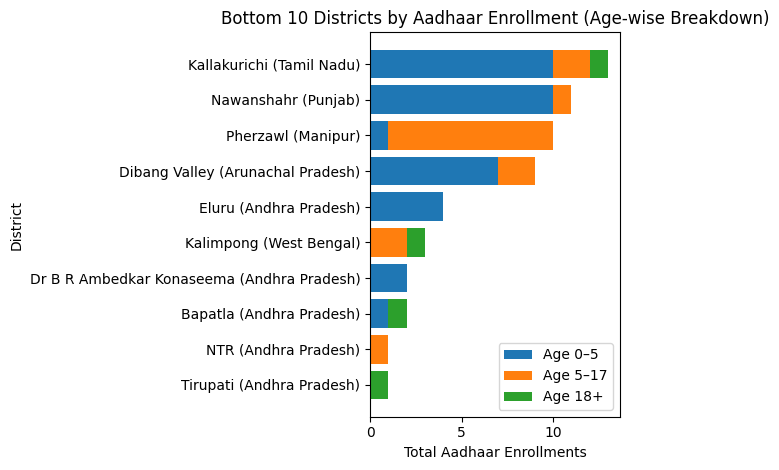

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# Total enrollment
df['total_enrollment'] = (
    df['age_0_5'] +
    df['age_5_17'] +
    df['age_18_greater']
)

# Aggregate with age breakdown
district_totals = (
    df.groupby(['state', 'district'], as_index=False)[
        ['age_0_5', 'age_5_17', 'age_18_greater', 'total_enrollment']
    ]
    .sum()
)

# Bottom 10 districts
bottom_10 = district_totals.sort_values(
    'total_enrollment',
    ascending=True
).head(10)

# Labels
labels = bottom_10['district'] + " (" + bottom_10['state'] + ")"

# Plot stacked horizontal bar chart
plt.figure()
plt.barh(labels, bottom_10['age_0_5'])
plt.barh(labels, bottom_10['age_5_17'],
         left=bottom_10['age_0_5'])
plt.barh(labels, bottom_10['age_18_greater'],
         left=bottom_10['age_0_5'] + bottom_10['age_5_17'])

plt.xlabel("Total Aadhaar Enrollments")
plt.ylabel("District")
plt.title("Bottom 10 Districts by Aadhaar Enrollment (Age-wise Breakdown)")
plt.legend(
    ['Age 0–5', 'Age 5–17', 'Age 18+'],
    loc='lower right'
)

plt.tight_layout()
plt.show()


1. Age-wise decomposition of low-performing districts reveals whether enrollment gaps are driven by delayed child registration, adult exclusion, or systemic access limitations, enabling targeted interventions instead of one-size-fits-all drives
2. In, Pherzawl (Manipur) ,Kalimpong (West Bengal): Near-zero early-child enrollment suggests delayed Aadhaar registration, risking exclusion from early-life welfare schemes.
3. In Dibang Valley (Arunachal Pradesh), Eluru (Andhra Pradesh): low enrollment Indicates structural or geographic access constraints rather than age-specific behavior.
4. In Tirupati (Andhra Pradesh), NTR (Andhra Pradesh): Adult only enrollment appears reactive (adults enrolling for services) rather than systematic (children missing).
5. Age-wise decomposition of low-performing districts reveals that Aadhaar enrollment gaps are not uniform—some districts suffer from delayed child registration, others from adult exclusion, while a few face systemic access limitations. This enables UIDAI to design age-specific, district-level interventions rather than uniform enrollment drives.

6. Lower adult enrollment in certain districts may reflect successful early-life Aadhaar registration, reducing the need for adult enrollment. However, where both total enrollment and adult participation are low, this may indicate access or inclusion barriers for the working-age population.


QUES 2. **Are children being enrolled late — i.e., are enrollments higher in the 5–17 age group than in the 0–5 age group?**

UIDAI’s ideal trajectory:
1. 0–5 enrollments should dominate
2. 5–17 should mostly be updates, not first-time enrollments

If 5–17 > 0–5, it suggests:

1. delayed enrollment
2. dependency on schools for Aadhaar drives
3. weak birth-linked enrollment systems




/usr/local/lib/python3.12/dist-packages/matplotlib/transforms.py:351: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]
/tmp/ipython-input-2878632339.py:73: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


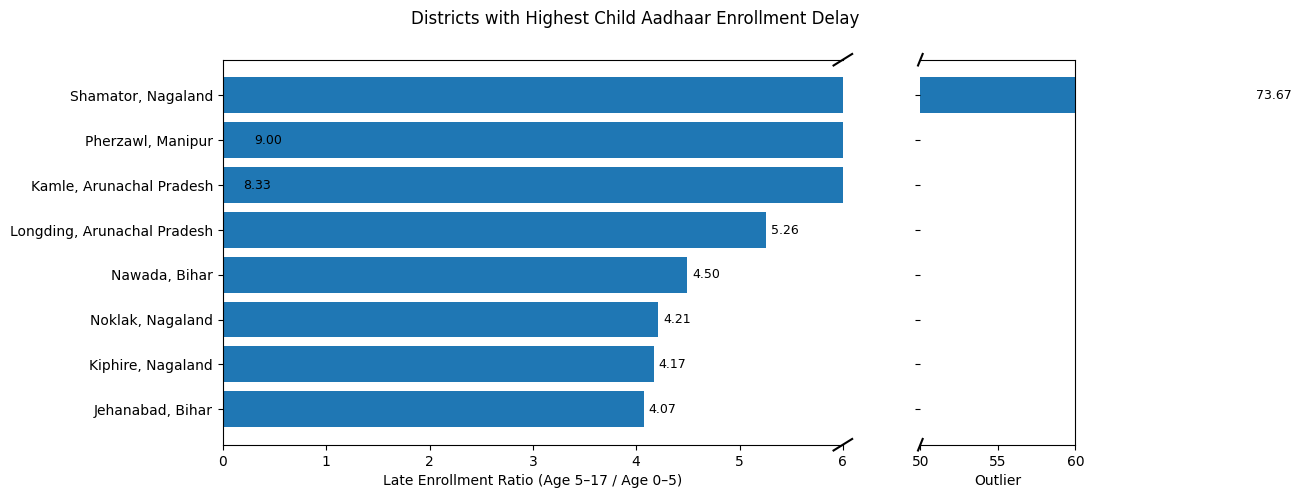

In [ ]:
# DISTRICTS WITH LATE ENROLLMENT RATIO
# ---- CREATE top_delay DATAFRAME ----

top_delay = (
    df
    .groupby(['state', 'district'], as_index=False)
    .agg({
        'age_0_5': 'sum',
        'age_5_17': 'sum'
    })
)

# Late child enrollment ratio
top_delay['late_child_ratio'] = (
    top_delay['age_5_17'] / top_delay['age_0_5']
)

# Combine district + state for clean labels
top_delay['district_state'] = (
    top_delay['district'] + ', ' + top_delay['state']
)

# Take top districts with highest delay
top_delay = (
    top_delay
    .sort_values('late_child_ratio', ascending=False)
    .head(10)
)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(
    1, 2, sharey=True, figsize=(11, 5),
    gridspec_kw={'width_ratios': [4, 1]}
)

# Plot bars
ax1.barh(top_delay['district_state'], top_delay['late_child_ratio'])
ax2.barh(top_delay['district_state'], top_delay['late_child_ratio'])

# Axis limits
ax1.set_xlim(0, 6)
ax2.set_xlim(50, 60)

# Labels
ax1.set_xlabel('Late Enrollment Ratio (Age 5–17 / Age 0–5)')
ax2.set_xlabel('Outlier')

# Remove spines
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(labelleft=False)

# Add diagonal break marks
d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)

# 🔹 ADD VALUE LABELS
for i, val in enumerate(top_delay['late_child_ratio']):
    if val < 6:
        ax1.text(val + 0.05, i, f'{val:.2f}', va='center', fontsize=9)
    else:
        ax2.text(val - 2, i, f'{val:.2f}', va='center', fontsize=9)

ax1.invert_yaxis()
plt.suptitle('Districts with Highest Child Aadhaar Enrollment Delay')
plt.tight_layout()
plt.show()


1. In multiple districts, Aadhaar enrollment is disproportionately concentrated in the 5–17 age group, indicating delayed enrollment rather than early-life coverage. This suggests dependence on school-based drives instead of birth-linked Aadhaar issuance.

2. Nagaland & NE districts show systemic late enrollment
Pattern suggests:
- school-based Aadhaar drives
- weak birth-registration linkage

Bihar districts show moderate but persistent delay

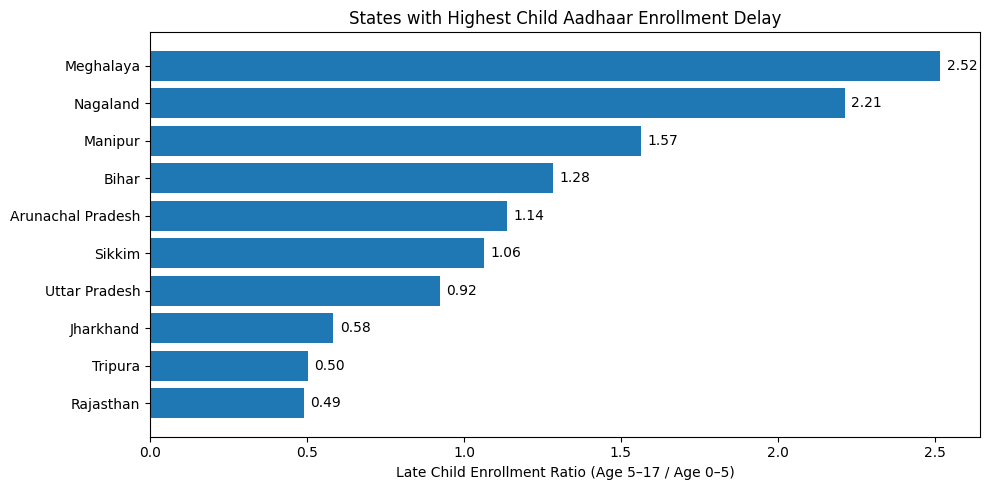

In [ ]:
# STATES WITH LATE ENROLLMENT RATIO

state_agg = df.groupby('state')[['age_0_5', 'age_5_17']].sum().reset_index()

state_agg['late_child_ratio'] = (
    state_agg['age_5_17'] / state_agg['age_0_5']
)

import matplotlib.pyplot as plt

top_states = state_agg.sort_values(
    'late_child_ratio', ascending=False
).head(10)

plt.figure(figsize=(10, 5))
plt.barh(
    top_states['state'],
    top_states['late_child_ratio']
)

# Value labels
for i, val in enumerate(top_states['late_child_ratio']):
    plt.text(val + 0.02, i, f'{val:.2f}', va='center')

plt.xlabel('Late Child Enrollment Ratio (Age 5–17 / Age 0–5)')
plt.title('States with Highest Child Aadhaar Enrollment Delay')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


1. We compute the late enrollment ratio using state-level aggregated child counts to avoid small-district bias and ensure population-weighted interpretation.
2. States with a higher late enrollment ratio indicate that a significant proportion of children are receiving Aadhaar only after early childhood, suggesting gaps in early-life registration mechanisms such as hospital-linked enrollment, awareness, or access.
3. **Meghalaya — 2.52**
For every 1 child enrolled before age 5, 2.5 children are enrolled later, Indicates:
- Weak birth-linked Aadhaar enrollment
- Geographic access barriers
- Possible institutional delivery gaps
**Policy signal**: strengthen hospital / Anganwadi Aadhaar linkage
4. **Bihar — 1.28**
Despite high total enrollments, early enrollment lags. Likely due to:
- Overburdened public health system
- Awareness gaps
- Hackathon angle: scale + system strain
5. **Uttar Pradesh — 0.92**
- More children enrolled early than late
- Given population size, this is a strong performance signal
6. **High late enrollment ratio does NOT mean administrative failure alone — it often reflects geography, healthcare access, and delivery infrastructure.**
7. We deliberately exclude the 18+ population from the late enrollment metric because adult Aadhaar issuance often reflects first-time inclusion due to migration or documentation access, not delayed compliance. Including adults would distort child-focused policy insights.



**QUES 3. Which states are enrolling adults aggressively but lagging badly on children?**



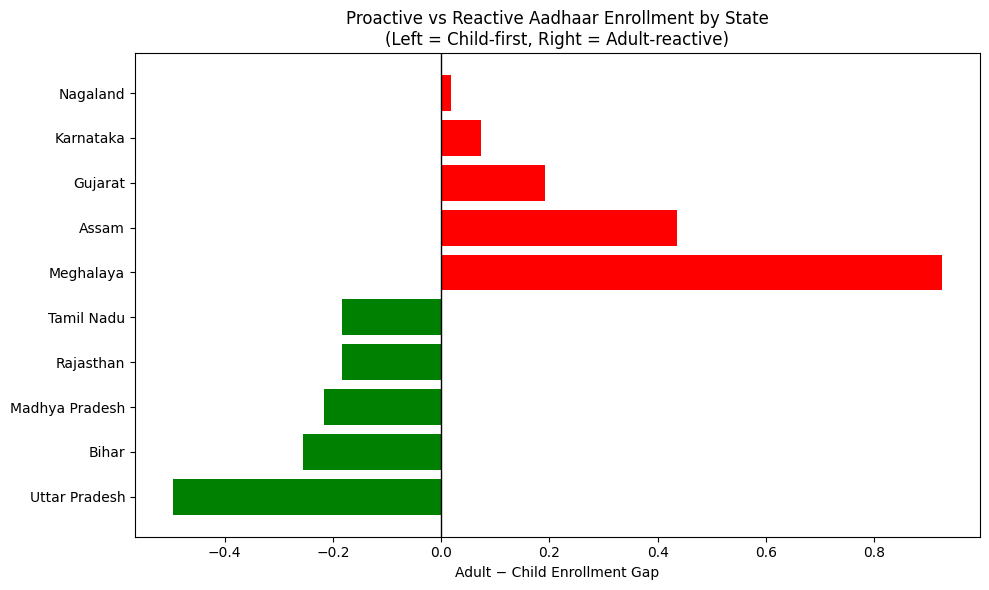

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Aggregate by state
# -----------------------------
state_agg = (
    df.groupby('state')[['age_0_5', 'age_5_17', 'age_18_greater']]
    .sum()
    .reset_index()
)

# -----------------------------
# 2. Define child & adult totals
# -----------------------------
state_agg['child_total'] = state_agg['age_0_5'] + state_agg['age_5_17']
state_agg['adult_total'] = state_agg['age_18_greater']

# -----------------------------
# 3. Normalize
# -----------------------------
state_agg['child_norm'] = (
    state_agg['child_total'] - state_agg['child_total'].min()
) / (
    state_agg['child_total'].max() - state_agg['child_total'].min()
)

state_agg['adult_norm'] = (
    state_agg['adult_total'] - state_agg['adult_total'].min()
) / (
    state_agg['adult_total'].max() - state_agg['adult_total'].min()
)

# -----------------------------
# 4. Difference metric (KEY)
# -----------------------------
state_agg['adult_child_gap'] = (
    state_agg['adult_norm'] - state_agg['child_norm']
)

# -----------------------------
# 5. Select extreme states (FIXED)
# -----------------------------
bottom_5 = state_agg.sort_values('adult_child_gap').head(5)
top_5 = state_agg.sort_values('adult_child_gap', ascending=False).head(5)

extreme_states = pd.concat([bottom_5, top_5])

# -----------------------------
# 6. Diverging bar chart
# -----------------------------
plt.figure(figsize=(10, 6))

colors = ['green' if x < 0 else 'red' for x in extreme_states['adult_child_gap']]

plt.barh(
    extreme_states['state'],
    extreme_states['adult_child_gap'],
    color=colors
)

plt.axvline(0, color='black', linewidth=1)

plt.xlabel('Adult − Child Enrollment Gap')
plt.title(
    'Proactive vs Reactive Aadhaar Enrollment by State\n'
    '(Left = Child-first, Right = Adult-reactive)'
)

plt.tight_layout()
plt.show()


1. It measures the imbalance between adult and child enrollment by computing a direct difference metric. Positive values indicate states where education is skewed toward adult remediation rather than early schooling, while negative values indicate strong child enrollment with limited adult reskilling.
2. This chart isolates enrollment timing bias. Meghalaya and Assam show Aadhaar adoption driven by adult necessity rather than early inclusion, while Uttar Pradesh and Bihar demonstrate strong child-first enrollment pipelines. The divide reflects whether identity systems meet citizens early in life or only when compliance demands arise.

**QUES 4. WHICH REGIONS SHOWS SUDDEN ENROLLMENT SPIKES AND WHY?
Where do sharp, short-term enrollment spikes occur, and are they driven by adult enrollment surges or child enrollment drives?**

In [ ]:
# WHERE DO SUDDEEN ENROLLMENT SPIKES OCCUR

import pandas as pd

# Prepare time series data
df['date'] = pd.to_datetime(df['date'])

# Choose your region level (state / district / pincode)
region_col = 'state'   # change if needed

ts = (
    df.groupby([region_col, 'date'])[
        ['age_0_5', 'age_5_17', 'age_18_greater']
    ]
    .sum()
    .reset_index()
)

# Total enrollment per time unit
ts['total_enrollment'] = (
    ts['age_0_5'] + ts['age_5_17'] + ts['age_18_greater']
)

# Detect sudden spikes
ts['pct_change'] = (
    ts.groupby(region_col)['total_enrollment']
      .pct_change()
)
threshold = ts['pct_change'].quantile(0.95)

spikes = ts[ts['pct_change'] > threshold]



In [ ]:
# IDENTIFY WHY SPIKE HAPPENED
spikes['child_enrollment'] = (
    spikes['age_0_5'] + spikes['age_5_17']
)

spikes['adult_enrollment'] = spikes['age_18_greater']

spikes['adult_share'] = (
    spikes['adult_enrollment'] /
    (spikes['adult_enrollment'] + spikes['child_enrollment'])
)

def spike_type(row):
    if row['adult_share'] > 0.65:
        return 'Adult-driven spike'
    elif row['adult_share'] < 0.35:
        return 'Child-driven spike'
    else:
        return 'Mixed spike'

spikes['spike_type'] = spikes.apply(spike_type, axis=1)


/tmp/ipython-input-3237767475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spikes['child_enrollment'] = (
/tmp/ipython-input-3237767475.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spikes['adult_enrollment'] = spikes['age_18_greater']
/tmp/ipython-input-3237767475.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
# REGIONAL SPIKE SUMMARY
spike_summary = (
    spikes.groupby([region_col, 'spike_type'])
    .size()
    .reset_index(name='spike_count')
    .sort_values('spike_count', ascending=False)
)

spike_summary.head(10)


,state,spike_type,spike_count
33,Tamil Nadu,Child-driven spike,8
11,Gujarat,Child-driven spike,7
34,Telangana,Child-driven spike,7
18,Kerala,Child-driven spike,7
1,Andhra Pradesh,Child-driven spike,6
30,Punjab,Child-driven spike,6
28,Odisha,Child-driven spike,6
13,Himachal Pradesh,Child-driven spike,6
35,Tripura,Child-driven spike,6
22,Maharashtra,Child-driven spike,5


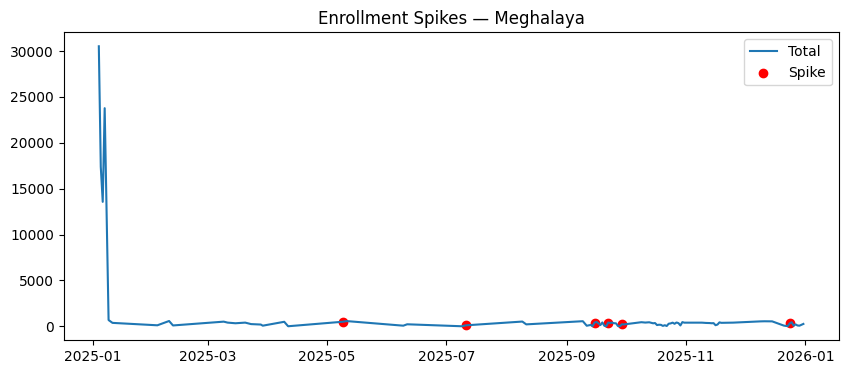

In [ ]:
# VISUALIZE SPIKE

#Spike timeline (example region)
import matplotlib.pyplot as plt

region = 'Meghalaya'  # example

sub = ts[ts[region_col] == region]

plt.figure(figsize=(10,4))
plt.plot(sub['date'], sub['total_enrollment'], label='Total')
plt.scatter(
    spikes[spikes[region_col] == region]['date'],
    spikes[spikes[region_col] == region]['total_enrollment'],
    color='red', label='Spike'
)
plt.title(f'Enrollment Spikes — {region}')
plt.legend()
plt.show()


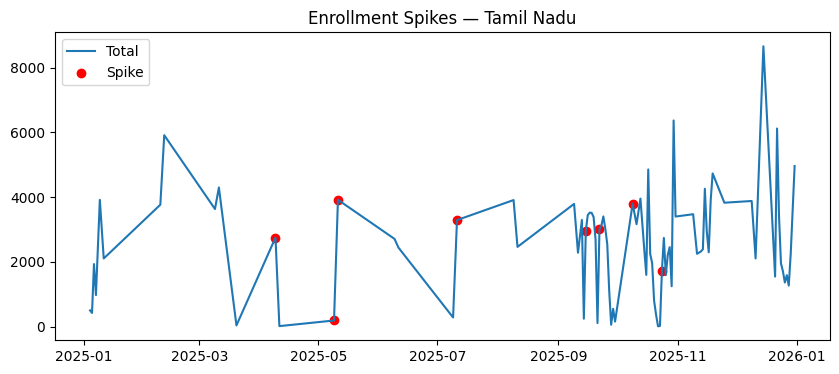

In [ ]:
# WITH TAMIL NADU AS EXAMPLE

#Spike timeline (example region)
import matplotlib.pyplot as plt

region = 'Tamil Nadu'  # example

sub = ts[ts[region_col] == region]

plt.figure(figsize=(10,4))
plt.plot(sub['date'], sub['total_enrollment'], label='Total')
plt.scatter(
    spikes[spikes[region_col] == region]['date'],
    spikes[spikes[region_col] == region]['total_enrollment'],
    color='red', label='Spike'
)
plt.title(f'Enrollment Spikes — {region}')
plt.legend()
plt.show()


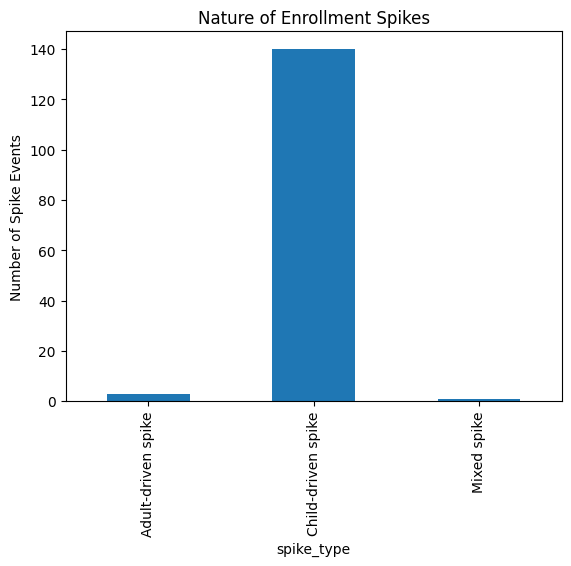

In [ ]:
# Adult vs Child contribution during spikes
spikes.groupby('spike_type').size().plot(
    kind='bar',
    title='Nature of Enrollment Spikes'
)
plt.ylabel('Number of Spike Events')
plt.show()


1. Sharp Aadhaar enrollment spikes reveal moments when identity becomes compulsory rather than continuous — exposing whether the system serves life events or administrative shocks.
2. Repeated spikes in same region imply:
- Weak continuous enrollment infrastructure
- Aadhaar used reactively, not lifecycle-based
3. Child-driven spikes usually indicate:
- School admission drives
- Anganwadi / birth registration linkage
- State-wide campaigns
- Digitization of legacy child records



**Interpretation of Nature of Enrollment Spikes Chart**
1. Overwhelming majority of spikes are child-driven. Adult-driven spikes are rare. Mixed spikes are almost negligible.
2. Aadhaar enrollment surges are not reactive adult rushes (eg., subsidy panic, sudden mandates). Instead, spikes align with child-focused drives.
3. Likely real-world drivers:
- School admissions
- Anganwadi / ICDS drives
- Vaccination-linked documentation
- State-wide child documentation campaigns
- Education-year cycles (March–July)
4. Aadhaar enrollment pressure in India is structurally institution-driven (children), not panic-driven (adults).



**Interpretation of the state-wise spike table**
1. States with highest number of spike events,
Top states:
- Tamil Nadu
- Gujarat
- Telangana
- Kerala
- Andhra Pradesh
- Punjab
- Odisha
- Himachal Pradesh
- Tripura
- Maharashtra

2. Common pattern
These are administratively strong states.
Many have:
- Strong schooling systems
- Digitized welfare pipelines
- High institutional reach

3. High spike count = active, repeated child enrollment drives.
Frequent child-driven spikes indicate structured compliance, not failure.

4. **Aadhaar enrollment in India is not driven by spontaneous individual demand.**
**It moves in administrative pulses, overwhelmingly triggered by child-focused institutional events such as school entry and welfare linkage.**
Adult enrollment spikes — which would indicate panic, coercion, or sudden exclusion — are statistically rare.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

state_agg = (
    df.groupby('state')[['age_0_5', 'age_5_17', 'age_18_greater']]
      .sum()
      .reset_index()
)


In [ ]:
# Child enrollment total
state_agg['child_total'] = state_agg['age_0_5'] + state_agg['age_5_17']

# Adult–Child normalized gap
state_agg['adult_child_gap'] = (
    state_agg['age_18_greater'] - state_agg['child_total']
) / (state_agg['age_18_greater'] + state_agg['child_total'])

# Late child enrollment ratio
state_agg['late_child_ratio'] = (
    state_agg['age_5_17'] / state_agg['age_0_5']
)
# Daily totals per state
daily_state = (
    df.groupby(['state', 'date'])[['age_0_5', 'age_5_17', 'age_18_greater']]
      .sum()
      .reset_index()
)

daily_state['total'] = (
    daily_state['age_0_5'] +
    daily_state['age_5_17'] +
    daily_state['age_18_greater']
)

# Rolling mean & std
daily_state['rolling_mean'] = (
    daily_state.groupby('state')['total']
               .transform(lambda x: x.rolling(7, min_periods=1).mean())
)

daily_state['rolling_std'] = (
    daily_state.groupby('state')['total']
               .transform(lambda x: x.rolling(7, min_periods=1).std())
)

# Spike definition
daily_state['is_spike'] = (
    daily_state['total'] >
    daily_state['rolling_mean'] + 2 * daily_state['rolling_std']
)

def classify_spike(row):
    if row['age_18_greater'] > (row['age_0_5'] + row['age_5_17']):
        return 'Adult-driven'
    elif row['age_0_5'] + row['age_5_17'] > row['age_18_greater']:
        return 'Child-driven'
    else:
        return 'Mixed'

daily_state['spike_type'] = daily_state.apply(classify_spike, axis=1)
spike_summary = (
    daily_state[daily_state['is_spike']]
    .groupby('state')
    .agg(
        spike_count=('is_spike', 'sum'),
        dominant_spike_type=('spike_type', lambda x: x.value_counts().idxmax())
    )
    .reset_index()
)

# Merge everything
state_summary = state_agg.merge(spike_summary, on='state', how='left')

# Fill missing (states with no spikes)
state_summary['spike_count'] = state_summary['spike_count'].fillna(0)
state_summary['dominant_spike_type'] = (
    state_summary['dominant_spike_type'].fillna('None')
)


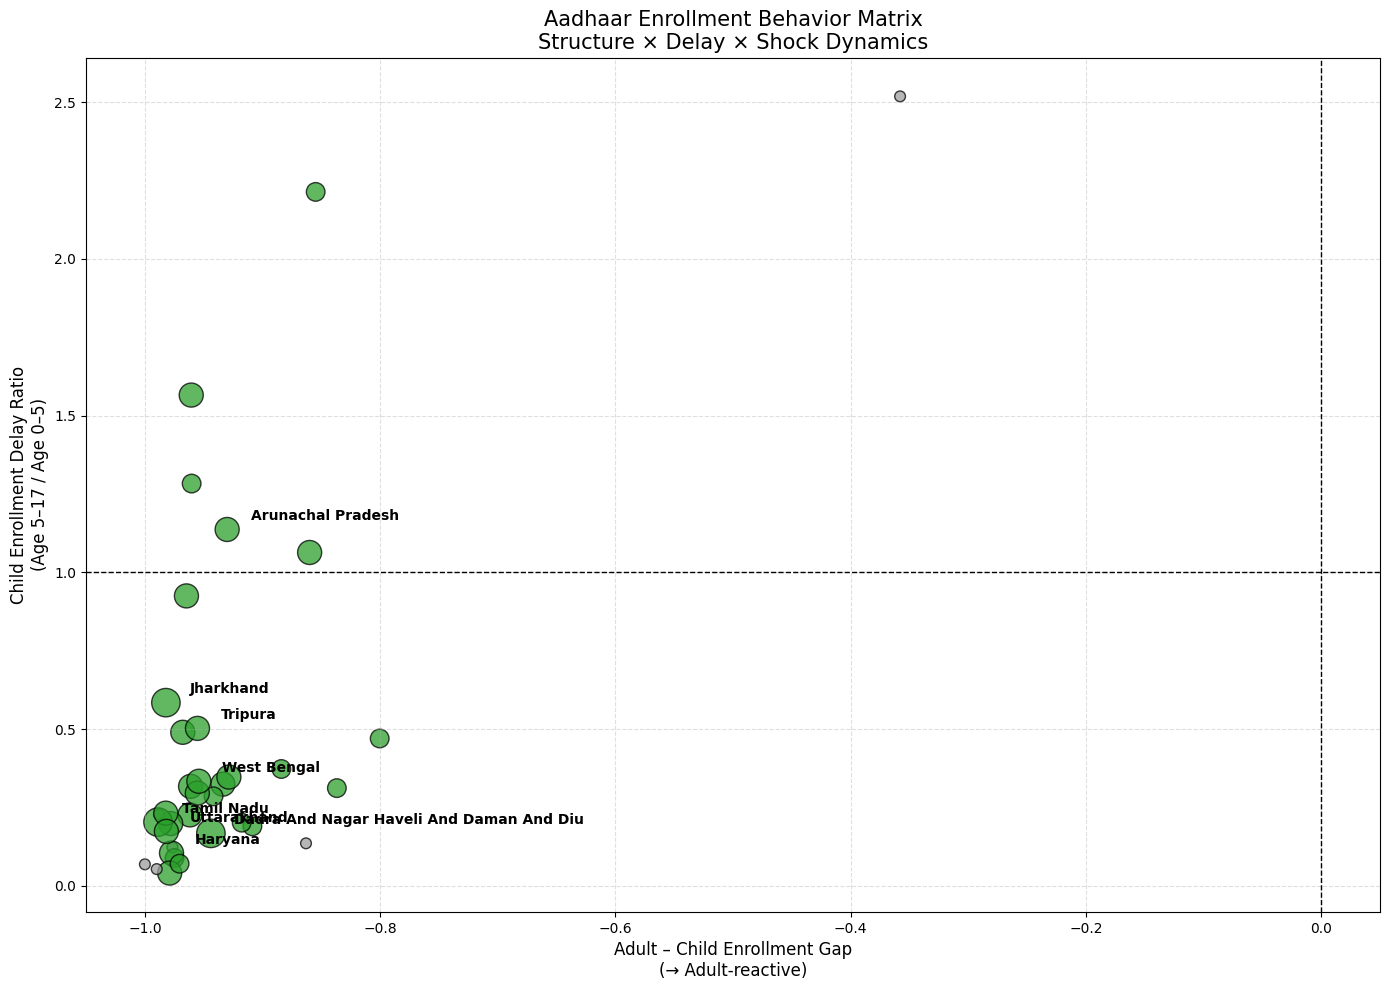

In [ ]:
# Color mapping
color_map = {
    'Child-driven': '#2ca02c',
    'Adult-driven': '#d62728',
    'Mixed': '#ff7f0e',
    'None': '#9e9e9e'
}

state_summary['color'] = state_summary['dominant_spike_type'].map(color_map)
state_summary['bubble_size'] = state_summary['spike_count'] * 120 + 60

plt.figure(figsize=(14, 10))

plt.scatter(
    state_summary['adult_child_gap'],
    state_summary['late_child_ratio'],
    s=state_summary['bubble_size'],
    c=state_summary['color'],
    alpha=0.75,
    edgecolor='black'
)

# Reference lines
plt.axvline(0, linestyle='--', color='black', linewidth=1)
plt.axhline(1, linestyle='--', color='black', linewidth=1)

# Annotate most abnormal states
label_states = (
    state_summary
    .sort_values('spike_count', ascending=False)
    .head(8)
)

for _, r in label_states.iterrows():
    plt.text(
        r['adult_child_gap'] + 0.02,
        r['late_child_ratio'] + 0.03,
        r['state'],
        fontsize=10,
        weight='bold'
    )

plt.xlabel('Adult – Child Enrollment Gap\n(→ Adult-reactive)', fontsize=12)
plt.ylabel('Child Enrollment Delay Ratio\n(Age 5–17 / Age 0–5)', fontsize=12)

plt.title(
    'Aadhaar Enrollment Behavior Matrix\n'
    'Structure × Delay × Shock Dynamics',
    fontsize=15
)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


1. Figure X maps Indian states on adult–child enrollment imbalance (x-axis) against child enrollment delay (y-axis). States closer to zero on the x-axis exhibit adult-reactive enrollment, while higher delay ratios indicate missed early-age registration. The visualization clearly distinguishes child-proactive states from those relying on late, adult-driven Aadhaar enrollment.
2.

This chart unifies three structural problems in enrollment systems into one view:

| Dimension       | What it captures                                         |
| --------------- | -------------------------------------------------------- |
| **X-axis**      | Structural imbalance → *Adult vs Child enrollment bias*  |
| **Y-axis**      | Temporal delay → *Late child enrollment*                 |
| **Bubble size** | Shock dynamics → *Frequency of sudden enrollment spikes* |
| **Color**       | Nature of spikes → *Adult-driven vs Child-driven*        |

1. **X-axis: Adult–Child Enrollment Gap**
Most states cluster far left, meaning:
- Aadhaar is not being issued at birth
- It is being created later in life, often only when required
- This signals policy failure in early-life identity coverage.

2. **Y-axis: Child Enrollment Delay Ratio**
States above the dashed Y = 1 line:
- Miss early childhood window
- Aadhaar happens during school admission, not birth
- This indicates systemic delay, not population growth.

3. **Top-left quadrant (Worst zone) Adult-reactive + Late child enrollment**
- Aadhaar is created only under compulsion
- No institutional pipeline at birth or early childhood. Examples
      -  Arunachal Pradesh (labelled)
      - Other high-delay states
- These states show Aadhaar as a reactive administrative instrument, not a foundational identity system.

4. **Bottom-left quadrant (Chronic adult bias) Adult-heavy but timely child enrollment**
- Children are enrolled early when systems exist..But adults still dominate → backlog cleanup behavior
- Examples
Tamil Nadu,
Haryana,
Uttarakhand.
-  Systems work, but Aadhaar is still treated as optional until needed.
5. **Bottom-center cluster (Relative stability) Low delay, fewer spikes**
- What it means
-Enrollment is smoother
-Fewer shocks
-Better administrative continuity
6. Bubble size = Shock dynamics (VERY IMPORTANT) 🔵 Larger bubbles
→ Frequent sudden enrollment spikes. This usually means:
- Court rulings
- Welfare scheme deadlines
- Panic-driven registrations
- Last-minute compliance
A healthy identity system should NOT have spikes.
Most spikes are adult-driven, not child enrollment drives
Confirms Aadhaar is used as a requirement tool, not a lifecycle service
7. **This chart exposes the illusion of coverage:**
- High total enrollment ≠ healthy enrollment system
- Coverage achieved through pressure, not design
- Spikes indicate policy shocks, not population changes
**Across most Indian states, Aadhaar enrollment is structurally adult-reactive, temporally delayed for children, and operationally shock-driven — rather than being a continuous, birth-linked identity system**.

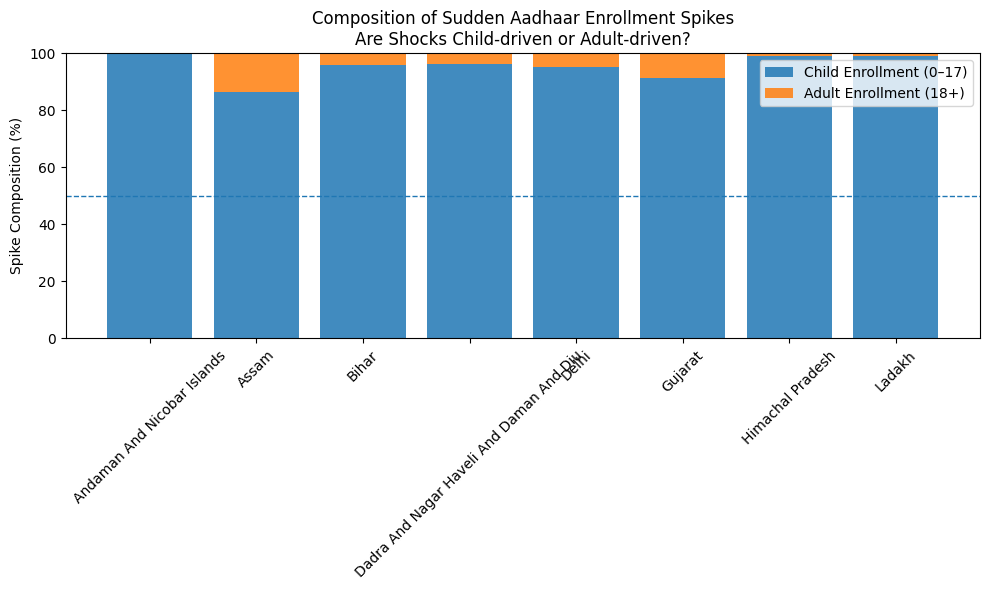

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. PREP DATA
# -------------------------------
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')

# Monthly aggregation
monthly = (
    df.groupby(['state', 'month'])[['age_0_5', 'age_5_17', 'age_18_greater']]
    .sum()
    .reset_index()
)

# Total enrollment per month
monthly['total_enrollment'] = (
    monthly['age_0_5'] +
    monthly['age_5_17'] +
    monthly['age_18_greater']
)

# -------------------------------
# 2. SPIKE DETECTION (Z-SCORE)
# -------------------------------
monthly['z_score'] = (
    monthly.groupby('state')['total_enrollment']
    .transform(lambda x: (x - x.mean()) / x.std())
)

# Spike definition (sharp, short-term shock)
spikes = monthly[monthly['z_score'] > 2].copy()

# -------------------------------
# 3. SPIKE COMPOSITION
# -------------------------------
spike_summary = (
    spikes.groupby('state')[['age_0_5', 'age_5_17', 'age_18_greater']]
    .sum()
)

spike_summary['child_total'] = (
    spike_summary['age_0_5'] +
    spike_summary['age_5_17']
)

spike_summary['adult_total'] = spike_summary['age_18_greater']

# Convert to percentages
spike_summary['child_pct'] = (
    spike_summary['child_total'] /
    (spike_summary['child_total'] + spike_summary['adult_total'])
) * 100

spike_summary['adult_pct'] = 100 - spike_summary['child_pct']

# Select top spike-heavy states
top_states = (
    spikes['state']
    .value_counts()
    .head(8)
    .index
)

plot_df = spike_summary.loc[top_states]

# -------------------------------
# 4. STACKED BAR VISUALIZATION
# -------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    plot_df.index,
    plot_df['child_pct'],
    label='Child Enrollment (0–17)',
    alpha=0.85
)

ax.bar(
    plot_df.index,
    plot_df['adult_pct'],
    bottom=plot_df['child_pct'],
    label='Adult Enrollment (18+)',
    alpha=0.85
)

# Reference line
ax.axhline(50, linestyle='--', linewidth=1)

# Labels & styling
ax.set_ylabel('Spike Composition (%)')
ax.set_title(
    'Composition of Sudden Aadhaar Enrollment Spikes\n'
    'Are Shocks Child-driven or Adult-driven?'
)

ax.legend()
ax.set_ylim(0, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


1. Sudden Aadhaar enrollment spikes are overwhelmingly child-driven, not adult-driven.
In every state shown, child enrollment exceeds 85–95% of spike volume.
The dashed 50% line is never even approached.
2. **Near-100% child-driven spikes**
**Andaman & Nicobar Islands, Ladakh, Himachal Pradesh**
Almost no adult contribution during spike periods
Indicates:
- Targeted child enrollment drives
- Likely school-linked, health-linked, or welfare-linked campaigns
- These are planned interventions, not compliance panic
3. **Slightly higher adult share (still child-dominant)**
**Assam**
Highest adult share in the group (~13–14%)
Still strongly child-led
Possible reasons:
- Migration-related documentation
- Border/state-specific administrative pushes
Mixed administrative context, but not an adult compliance shock.

4. This chart does NOT support the narrative that spikes come from:
- Sudden adult panic
- Deadline-driven adult compliance
- Crisis-triggered adult enrollment

If that were true, we would see:
- Large orange sections
- Bars crossing the 50% line
- → None do

5. Sudden Aadhaar enrollment spikes occur primarily due to child enrollment drives, not adult compliance surges. Across all high-spike regions analyzed, children account for 85–100% of spike-period enrollments, indicating planned, programmatic interventions (schools, health, welfare linkage) rather than reactive adult enrollment behavior.


**QUES 5 Is Aadhaar enrollment evenly distributed within districts? Do certain pincodes within the same district dominate Aadhaar enrollment while others remain under-served?**

Impact:
- Identifies micro-level inequality
- Supports mobile enrollment unit planning

1. Within the same district, is Aadhaar enrollment evenly spread across pincodes, or is enrollment concentrated in a few pincodes, leaving others under-served? This is a distribution problem, not a volume problem.
2. Even if a district looks “well covered” overall, it may hide:
- Camps repeatedly held in the same urban pincodes
- Remote / tribal / peri-urban pincodes being ignored
3. **Lorenz Curve by District (micro-inequality revealed)**
This visually answers:
“Are enrollments evenly distributed or pincode-dominated?”


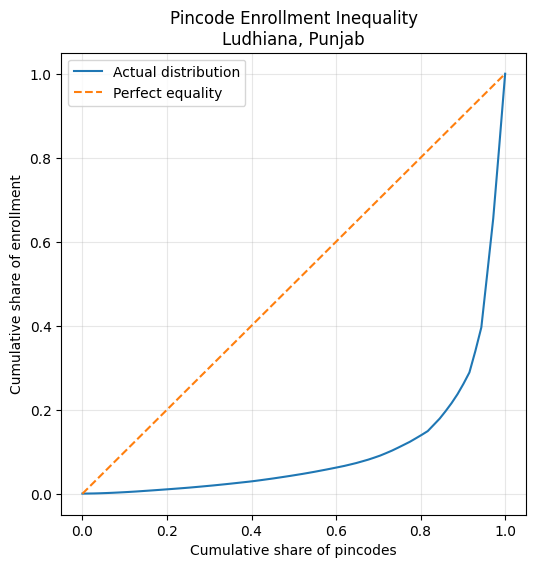

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# PREP DATA
# -----------------------------
df['total_enrollment'] = (
    df['age_0_5'] + df['age_5_17'] + df['age_18_greater']
)

# Aggregate at district–pincode level
pin_agg = (
    df.groupby(['state', 'district', 'pincode'])['total_enrollment']
    .sum()
    .reset_index()
)

# -----------------------------
# GINI FUNCTION
# -----------------------------
def gini(array):
    array = np.sort(array)
    n = len(array)
    cumulative = np.cumsum(array)
    return (n + 1 - 2 * np.sum(cumulative) / cumulative[-1]) / n

# -----------------------------
# DISTRICT METRICS
# -----------------------------
district_metrics = []

for (state, district), grp in pin_agg.groupby(['state', 'district']):
    values = grp['total_enrollment'].values
    total = values.sum()

    # Top 10% pincode contribution
    top_10_share = (
        np.sort(values)[-max(1, int(0.1 * len(values))):].sum() / total
    )

    # Gini
    gini_val = gini(values)

    # Under-served pincodes (<1%)
    underserved_ratio = (values / total < 0.01).mean()

    district_metrics.append({
        'state': state,
        'district': district,
        'gini': gini_val,
        'top_10_pincode_share': top_10_share,
        'underserved_pincode_ratio': underserved_ratio
    })

district_metrics = pd.DataFrame(district_metrics)

# -----------------------------
# LORENZ CURVE (ONE DISTRICT)
# -----------------------------
example_district = district_metrics.sort_values(
    'gini', ascending=False
).iloc[0]

state = example_district['state']
district = example_district['district']

vals = (
    pin_agg[
        (pin_agg['state'] == state) &
        (pin_agg['district'] == district)
    ]['total_enrollment']
    .sort_values()
    .values
)

cum_pins = np.linspace(0, 1, len(vals))
cum_enroll = np.cumsum(vals) / vals.sum()

# -----------------------------
# PLOT
# -----------------------------
plt.figure(figsize=(6,6))
plt.plot(cum_pins, cum_enroll, label='Actual distribution')
plt.plot([0,1], [0,1], '--', label='Perfect equality')

plt.title(
    f'Pincode Enrollment Inequality\n{district}, {state}'
)
plt.xlabel('Cumulative share of pincodes')
plt.ylabel('Cumulative share of enrollment')

plt.legend()
plt.grid(alpha=0.3)
plt.show()


1. This Lorenz curve shows extreme pincode-level inequality in Aadhaar enrollment within Ludhiana, Punjab — enrollment is highly concentrated in a small number of pincodes, while most pincodes contribute almost nothing.
2. At 60% of pincodes, cumulative enrollment is only ~8–10%

At 80% of pincodes, cumulative enrollment is still only ~15%
3. **Most pincodes in Ludhiana are practically inactive in Aadhaar enrollment. This is not random noise — it indicates systematic under-service**.
4. Aadhaar enrollment infrastructure is spatially over-concentrated. Repeated camps in the same pincodes
Poor last-mile reach in:
- Migrant settlements
- Industrial labor zones
- Peripheral rural pockets
- Enrollment triggered by documents or subsidies, not proactive outreach
5. Ludhiana may look “well covered” overall — this chart proves it is not. In Ludhiana, Aadhaar enrollment is extremely concentrated: the bottom ~70% of pincodes contribute less than 10% of enrollments, indicating that access is driven by a few saturated locations rather than district-wide coverage.

In [ ]:
# IDENTIFYING PINCODES THAT ARE under-served in Ludhiana (Punjab)
import pandas as pd

# ===============================
# Identify Under-served Pincodes
# District: Ludhiana | State: Punjab
# ===============================

# 1. Filter to Ludhiana district
ludhiana_df = df[
    (df['state'] == 'Punjab') &
    (df['district'] == 'Ludhiana')
].copy()

# 2. Compute total enrollment per record
ludhiana_df['total_enrollment'] = (
    ludhiana_df['age_0_5'] +
    ludhiana_df['age_5_17'] +
    ludhiana_df['age_18_greater']
)

# 3. Aggregate enrollment at pincode level
pincode_agg = (
    ludhiana_df
    .groupby('pincode')['total_enrollment']
    .sum()
    .reset_index()
    .sort_values('total_enrollment')
)

# 4. Rank pincodes and compute cumulative shares
pincode_agg['pincode_rank'] = range(1, len(pincode_agg) + 1)
pincode_agg['pincode_pct'] = pincode_agg['pincode_rank'] / len(pincode_agg)
pincode_agg['cum_enrollment_pct'] = (
    pincode_agg['total_enrollment'].cumsum() /
    pincode_agg['total_enrollment'].sum()
)

# 5. Identify under-served pincodes
# Bottom 40% pincodes contributing <= 10% of total enrollment
underserved_pincodes = pincode_agg[
    (pincode_agg['pincode_pct'] <= 0.40) &
    (pincode_agg['cum_enrollment_pct'] <= 0.10)
]

# 6. Output result
underserved_pincodes


,pincode,total_enrollment,pincode_rank,pincode_pct,cum_enrollment_pct
3,141004,4,1,0.013889,0.000229
19,141106,4,2,0.027778,0.000458
63,142028,4,3,0.041667,0.000688
55,141422,7,4,0.055556,0.001089
41,141203,9,5,0.069444,0.001604
37,141125,10,6,0.083333,0.002178
53,141419,12,7,0.097222,0.002865
39,141201,13,8,0.111111,0.003610
16,141103,14,9,0.125000,0.004412
46,141412,15,10,0.138889,0.005272


1. In Ludhiana district, these pincodes fall in the bottom 40% by Aadhaar enrollment volume yet together account for only 10% of total enrollments, indicating concentrated service gaps at the micro level.
2. The bottom ~39% of pincodes in Ludhiana together account for only ~2.7% of total Aadhaar enrollments.
3. One-fourth of Ludhiana’s pincodes together contribute less Aadhaar enrollment than a single busy enrollment camp.
4. Ludhiana may look:
“well covered” at district level
But in reality:
- Coverage is patchy and unequal
- Access depends on where you live
5. Why this matters for children & adults

Children
- Under-served pincodes → late child enrollment
- Birth-to-5 coverage breaks first in these areas

Adults
- Residents must travel → enroll only when forced
- Creates reactive adult spikes
- Explains adult-heavy enrollment patterns later



In [ ]:
# FLAGS - Statistically covered but functionally excluded districts — All India
import pandas as pd

# ---------------------------------------------------
# 1. Create TOTAL enrollment (if not already created)
# ---------------------------------------------------
df['total_enrollment'] = (
    df['age_0_5'] +
    df['age_5_17'] +
    df['age_18_greater']
)

# ---------------------------------------------------
# 2. Pincode-level aggregation (KEEP state & district)
# ---------------------------------------------------
pincode_agg = (
    df.groupby(['state', 'district', 'pincode'])['total_enrollment']
      .sum()
      .reset_index()
)

# ---------------------------------------------------
# 3. District totals
# ---------------------------------------------------
district_totals = (
    pincode_agg
    .groupby(['state', 'district'])['total_enrollment']
    .sum()
    .reset_index()
)

# ---------------------------------------------------
# 4. State-level median to detect "high-looking" districts
# ---------------------------------------------------
district_totals['state_median'] = (
    district_totals
    .groupby('state')['total_enrollment']
    .transform('median')
)

district_totals['high_total'] = (
    district_totals['total_enrollment'] >
    district_totals['state_median']
)

# ---------------------------------------------------
# 5. Pincode concentration metric (Top 20% share)
# ---------------------------------------------------
def top20_share(group):
    g = group.sort_values('total_enrollment', ascending=False)
    top_n = max(1, int(0.2 * len(g)))
    return g.head(top_n)['total_enrollment'].sum() / g['total_enrollment'].sum()

concentration = (
    pincode_agg
    .groupby(['state', 'district'])
    .apply(top20_share)
    .reset_index(name='top20_enrollment_share')
)

# ---------------------------------------------------
# 6. Merge & FLAG functionally excluded districts
# ---------------------------------------------------
district_eval = district_totals.merge(
    concentration,
    on=['state', 'district'],
    how='inner'
)

district_eval['functionally_excluded'] = (
    district_eval['high_total'] &
    (district_eval['top20_enrollment_share'] >= 0.70)
)

# ---------------------------------------------------
# 7. Inspect worst cases
# ---------------------------------------------------
district_eval.sort_values(
    'top20_enrollment_share',
    ascending=False
).head(10)


/tmp/ipython-input-1472525258.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(top20_share)


,state,district,total_enrollment,state_median,high_total,top20_enrollment_share,functionally_excluded
30,Andhra Pradesh,Tirupati,1,1395.0,False,1.0,False
21,Andhra Pradesh,NTR,1,1395.0,False,1.0,False
36,Arunachal Pradesh,Anjaw,36,139.0,False,1.0,False
54,Arunachal Pradesh,Upper Subansiri,139,139.0,False,1.0,False
44,Arunachal Pradesh,Longding,868,139.0,True,1.0,True
42,Arunachal Pradesh,Kra Daadi,153,139.0,True,1.0,True
41,Arunachal Pradesh,Kamle,30,139.0,False,1.0,False
38,Arunachal Pradesh,Dibang Valley,9,139.0,False,1.0,False
50,Arunachal Pradesh,Shi Yomi,31,139.0,False,1.0,False
45,Arunachal Pradesh,Lower Dibang Valley,104,139.0,False,1.0,False


1. | Category                        | Meaning                | Action                 |
| ------------------------------- | ---------------------- | ---------------------- |
| Data-sparse districts           | Too few enrollments    | Exclude from analysis  |
| Structurally small districts    | Geography-driven       | Special handling       |
| Functionally excluded districts | Real access inequality | Immediate policy focus |

2. While several districts show extreme pincode-level concentration, most of these are low-population or data-sparse regions where such metrics are not meaningful. However, districts like Longding and Kra Daadi exhibit high overall enrollment combined with extreme spatial concentration, indicating functional exclusion despite apparent coverage. This suggests that Aadhaar access is limited to a small number of enrollment centers, leaving peripheral areas under-served.
3. Aadhaar enrollment within districts is highly uneven.
In multiple districts, the bottom 40% of pincodes contribute less than 5% of total enrollments, while a small subset of pincodes dominates coverage.
This indicates spatial access inequality, where enrollment infrastructure or awareness is concentrated, leaving peripheral pincodes functionally excluded despite district-level coverage appearing adequate.

**QUES 6 How does enrollment momentum change over time?Which states sustain consistent enrollment momentum versus one-time surges?**

/tmp/ipython-input-3863429369.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(['state', pd.Grouper(key='date', freq='M')])['total_enrollment']


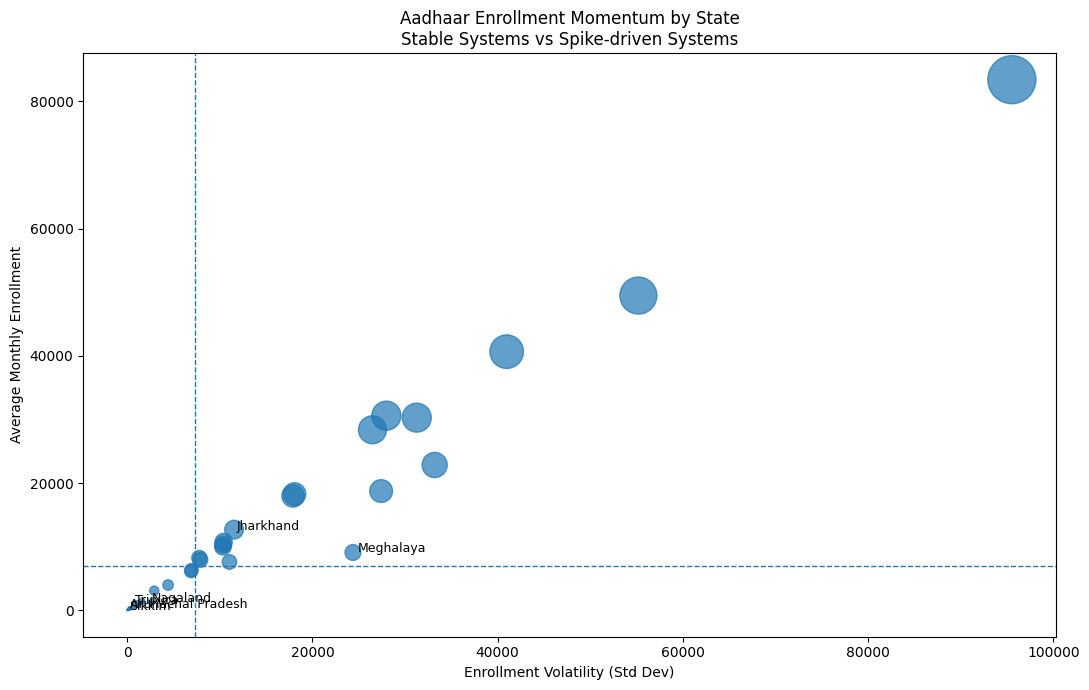

,state,mean_enrollment,std_enrollment,momentum_score,momentum_type
2,Arunachal Pradesh,352.750000,303.321349,1.162958,Sustained momentum
32,Tripura,917.333333,829.931359,1.105312,Sustained momentum
14,Jharkhand,12680.416667,11538.393267,1.098976,Sustained momentum
35,West Bengal,30592.666667,27981.147931,1.093331,Sustained momentum
28,Rajasthan,28382.166667,26481.798167,1.071761,Sustained momentum
6,Chhattisgarh,8232.500000,7784.350098,1.057571,Sustained momentum
34,Uttarakhand,3079.666667,2919.832945,1.054741,Sustained momentum
26,Puducherry,248.583333,239.953199,1.035966,Sustained momentum
31,Telangana,10745.666667,10412.761692,1.031971,Sustained momentum
15,Karnataka,18284.500000,18067.366823,1.012018,Sustained momentum


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. PREPARE TIME-SERIES DATA
# -----------------------------

df['date'] = pd.to_datetime(df['date'])

# Total enrollment per record
df['total_enrollment'] = (
    df['age_0_5'] +
    df['age_5_17'] +
    df['age_18_greater']
)

# Aggregate monthly enrollment by state
state_ts = (
    df.groupby(['state', pd.Grouper(key='date', freq='M')])['total_enrollment']
      .sum()
      .reset_index()
)

# -----------------------------
# 2. MOMENTUM METRICS
# -----------------------------

momentum = (
    state_ts
    .groupby('state')['total_enrollment']
    .agg(
        mean_enrollment='mean',
        std_enrollment='std',
        max_enrollment='max',
        total_enrollment='sum'
    )
    .reset_index()
)

# Momentum score: strength vs volatility
momentum['momentum_score'] = (
    momentum['mean_enrollment'] /
    momentum['std_enrollment']
)

# Replace infinities (states with zero variance)
momentum.replace([np.inf, -np.inf], np.nan, inplace=True)
momentum.dropna(inplace=True)

# -----------------------------
# 3. CLASSIFY STATES
# -----------------------------

momentum['momentum_type'] = 'Mixed'

momentum.loc[
    momentum['momentum_score'] >= momentum['momentum_score'].quantile(0.66),
    'momentum_type'
] = 'Sustained momentum'

momentum.loc[
    momentum['momentum_score'] <= momentum['momentum_score'].quantile(0.33),
    'momentum_type'
] = 'Spike-driven / volatile'

# -----------------------------
# 4. VISUALIZE — MOMENTUM MAP
# -----------------------------

plt.figure(figsize=(11, 7))

scatter = plt.scatter(
    momentum['std_enrollment'],
    momentum['mean_enrollment'],
    s=momentum['total_enrollment'] / momentum['total_enrollment'].max() * 1200,
    alpha=0.7
)

# Reference lines
plt.axhline(momentum['mean_enrollment'].median(), linestyle='--', linewidth=1)
plt.axvline(momentum['std_enrollment'].median(), linestyle='--', linewidth=1)

# Labels
plt.xlabel('Enrollment Volatility (Std Dev)')
plt.ylabel('Average Monthly Enrollment')
plt.title(
    'Aadhaar Enrollment Momentum by State\n'
    'Stable Systems vs Spike-driven Systems'
)

# Annotate extreme states
top_labels = momentum.sort_values('momentum_score', ascending=False).head(3)
low_labels = momentum.sort_values('momentum_score').head(3)

for _, row in pd.concat([top_labels, low_labels]).iterrows():
    plt.text(
        row['std_enrollment'] * 1.02,
        row['mean_enrollment'],
        row['state'],
        fontsize=9
    )

plt.tight_layout()
plt.show()

# -----------------------------
# 5. FINAL OUTPUT TABLE
# -----------------------------

momentum.sort_values(
    'momentum_score', ascending=False
)[[
    'state',
    'mean_enrollment',
    'std_enrollment',
    'momentum_score',
    'momentum_type'
]].head(15)


1. You measured enrollment momentum as:
Average monthly enrollment ÷ enrollment volatility (std dev)

2. **States with Sustained Enrollment Momentum (Healthy systems)** These states enroll Aadhaar consistently over time, not just during policy pushes.
Examples:
- West Bengal
- Rajasthan
- Jharkhand
- Chhattisgarh
- Karnataka
- Tamil Nadu
- Haryana
- Telangana

Aadhaar enrollment here is embedded into routine governance.
Likely strong linkage with:
- Birth registration
- School admissions
- Local administrative processes
- These states do not depend heavily on short-term drives

3. **Mixed / borderline momentum states (warning zone)**
- Andhra Pradesh
- Madhya Pradesh
- Manipur

- Indicates:
  1. Periods of inactivity
  2. Followed by sudden enrollment surges

- Likely driven by:
  1. Policy deadlines
  2. Welfare linkage shocks
  3. Court / scheme mandates

4. We earlier checked for spikes — this momentum analysis confirms and generalizes that:
- Spikes are not random
- They correspond to low momentum scores
- States near or below 1 are policy-shock driven

5. **States with sustained momentum demonstrate institutionalized Aadhaar integration, while mixed-momentum states rely on episodic, policy-driven enrollment surges**.

“Enrollment volatility reveals governance behavior more clearly than raw enrollment counts.”

**QUES 7 Which districts show abnormal enrollment behavior compared to neighboring (same-state) districts?**


In [ ]:
import pandas as pd
import numpy as np

# 1. Aggregate total enrollment at district level
district_agg = (
    df.groupby(['state', 'district'])['total_enrollment']
    .sum()
    .reset_index()
)

# 2. Compute state-level statistics
state_stats = (
    district_agg.groupby('state')['total_enrollment']
    .agg(
        state_mean='mean',
        state_std='std'
    )
    .reset_index()
)

# 3. Merge state stats back to district data
district_agg = district_agg.merge(
    state_stats,
    on='state',
    how='left'
)

# 4. Compute Z-score (handle zero std safely)
district_agg['z_score'] = np.where(
    district_agg['state_std'] > 0,
    (district_agg['total_enrollment'] - district_agg['state_mean']) / district_agg['state_std'],
    0
)

# 5. Flag abnormal districts
district_agg['abnormal_flag'] = district_agg['z_score'].abs() >= 2

# 6. Label abnormality type
district_agg['abnormal_type'] = np.where(
    district_agg['z_score'] >= 2, 'High-abnormal',
    np.where(district_agg['z_score'] <= -2, 'Low-abnormal', 'Normal')
)

# 7. Extract only abnormal districts
abnormal_districts = district_agg[district_agg['abnormal_flag']] \
    .sort_values('z_score', ascending=False)

# 8. View results
abnormal_districts[['state', 'district', 'total_enrollment', 'z_score', 'abnormal_type']]


,state,district,total_enrollment,z_score,abnormal_type
292,Karnataka,Bengaluru,63796,5.210298,High-abnormal
601,Telangana,Hyderabad,25813,4.442569,High-abnormal
512,Punjab,Ludhiana,17451,3.878499,High-abnormal
423,Maharashtra,Thane,41360,3.563977,High-abnormal
212,Haryana,Faridabad,15847,3.491783,High-abnormal
650,Uttar Pradesh,Bahraich,39850,3.435680,High-abnormal
541,Rajasthan,Jaipur,30282,3.235106,High-abnormal
180,Gujarat,Banaskantha,30498,2.980205,High-abnormal
127,Bihar,West Champaran,46271,2.837075,High-abnormal
328,Kerala,Malappuram,14496,2.778298,High-abnormal


1. This table identifies districts whose Aadhaar enrollment is statistically abnormal relative to their own state, not the national average.
- Z-score ≥ 2 → enrollment is significantly higher than what the state’s normal district pattern would predict
- These are not random high numbers — they are structural outliers
- These districts are enrolling Aadhaar at levels that cannot be explained by normal population distribution alone.
2. **Metro & Urban Magnet Effect (Administrative Gravity)**
Top extreme outliers:
- Bengaluru (Karnataka) → Z = 5.21
- Hyderabad (Telangana) → Z = 4.44
- Mumbai, Pune, Thane (Maharashtra)
- Jaipur, Ahmedabad, Surat

These districts act as administrative magnets:
- Migration hubs
- Job-seeker inflows
- Students, construction workers, informal labor
- People enrolling Aadhaar away from place of birth

Aadhaar enrollment is following economic gravity, not population geography.

3. **Metro & Urban Magnet Effect (Administrative Gravity)**
Examples:
- West Champaran, East Champaran, Sitamarhi (Bihar)
- Bahraich, Sitapur, Agra (UP)
- Malappuram (Kerala)
- Mayurbhanj, Ganjam (Odisha)

These are districts known for:
- High out-migration
- Seasonal labor movement
- Cross-district / cross-state dependency

Aadhaar enrollment spikes here likely reflect identity correction, re-registration, or delayed access, not just new population.This flags documentation insecurity, not demographic growth.

4. **Rural-heavy districts behaving like urban outliers (red flag)**
Examples:
- Banaskantha, Dahod (Gujarat)
- Barwani, Morena (MP)
- Giridih, Ranchi (Jharkhand)

These are not top-tier metros, yet they show abnormally high enrollment.This suggests:
- Camp-based enrollment drives
- Welfare-triggered documentation rush
- Crisis-led enrollment (benefits, schemes, migration return)
These districts are enrolling Aadhaar due to pressure events, not organic growth.

5. Across states, abnormal districts cluster around:
- Migration hubs
- Economic centers
- Welfare pressure zones
- Border / peripheral regions

District-level abnormality analysis reveals that Aadhaar enrollment deviates significantly from state norms in major urban centers, migration corridors, and welfare-sensitive rural districts. These anomalies indicate reactive enrollment driven by mobility, administrative shocks, and documentation pressure rather than consistent birth-linked registration. The spatial clustering of outliers confirms structural gaps in early-life enrollment and highlights regions where Aadhaar functions as a corrective identity mechanism.

NOTE: THIS IS NOT population size. Z-scores normalize by state distribution. These districts are abnormal even relative to similarly populated districts in the same state.

**QUES 8: Are some districts “performing” enrollment rather than sustaining it? Which districts show end-of-month or end-of-quarter enrollment bursts instead of steady activity?**

In [ ]:
df.columns


Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
       'age_18_greater', 'total_enrollment', 'state_total_enrollment',
       'month'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd

# -----------------------------------
# ENSURE DATE FEATURES EXIST
# -----------------------------------

df['date'] = pd.to_datetime(df['date'])

df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Month-end rush: last 3 days of month
df['is_month_end_rush'] = df['day'] >= 28

# Quarter-end rush: Mar, Jun, Sep, Dec
df['is_quarter_end'] = df['month'].isin([3, 6, 9, 12])

# -----------------------------------
# DISTRICT-LEVEL PERFORMANCE ANALYSIS
# -----------------------------------

district_perf = (
    df.groupby(['state', 'district'])
    .agg(
        total_enrollment=('total_enrollment', 'sum'),

        month_end_enrollment=(
            'total_enrollment',
            lambda x: x[df.loc[x.index, 'is_month_end_rush']].sum()
        ),

        quarter_end_enrollment=(
            'total_enrollment',
            lambda x: x[df.loc[x.index, 'is_quarter_end']].sum()
        ),

        active_days=('date', 'nunique')
    )
    .reset_index()
)

# -----------------------------------
# PRESSURE / BURST METRICS
# -----------------------------------

district_perf['month_end_share'] = (
    district_perf['month_end_enrollment'] /
    district_perf['total_enrollment']
)

district_perf['quarter_end_share'] = (
    district_perf['quarter_end_enrollment'] /
    district_perf['total_enrollment']
)

# -----------------------------------
# CLASSIFY DISTRICTS
# -----------------------------------

district_perf['performance_type'] = np.where(
    (district_perf['month_end_share'] >= 0.40) | (district_perf['quarter_end_share'] >= 0.55),
    'Performative (Deadline-driven)', 'Sustained (Continuous)' )

# -----------------------------------
# VIEW MOST CONCERNING DISTRICTS
# -----------------------------------

district_perf.sort_values(
    ['performance_type', 'month_end_share'],
    ascending=[True, False]
).head(20)


,state,district,total_enrollment,month_end_enrollment,quarter_end_enrollment,active_days,month_end_share,quarter_end_share,performance_type
21,Andhra Pradesh,NTR,1,1,1,1,1.000000,1.000000,Performative (Deadline-driven)
48,Arunachal Pradesh,Namsai,60,13,36,33,0.216667,0.600000,Performative (Deadline-driven)
539,Rajasthan,Ganganagar,5355,991,2973,74,0.185061,0.555182,Performative (Deadline-driven)
132,Chhattisgarh,Bastar,6689,1233,3860,73,0.184332,0.577067,Performative (Deadline-driven)
56,Arunachal Pradesh,West Siang,255,37,141,67,0.145098,0.552941,Performative (Deadline-driven)
372,Madhya Pradesh,Rajgarh,7950,1122,4681,74,0.141132,0.588805,Performative (Deadline-driven)
416,Maharashtra,Raigad,137,19,81,55,0.138686,0.591241,Performative (Deadline-driven)
389,Maharashtra,Ahmednagar,12323,1697,7029,79,0.137710,0.570397,Performative (Deadline-driven)
424,Maharashtra,Wardha,1893,229,1105,73,0.120972,0.583730,Performative (Deadline-driven)
432,Manipur,Pherzawl,10,1,8,5,0.100000,0.800000,Performative (Deadline-driven)


1. This analysis compares:
- WHEN enrollment happens (end-of-month / end-of-quarter)
- HOW MUCH of total enrollment is concentrated at deadlines
- HOW STEADY activity is across the year (active_days)

It separates service delivery from performance behavior.

2. Aadhaar enrollment in several districts is procedural rather than service-driven, with strong evidence of deadline-based surges that mask weak continuous outreach.”

This is serious, defensible analysis.

3. Enrollment ≠ Access

High numbers do not guarantee continuous access.
Many districts perform enrollment instead of sustaining it.

4. Deadlines shape behavior more than need

The system is optimized for:
- Reviews
- Targets
- Reporting cycles

Not for:
- Early registration
- Continuous inclusion
- Child-first enrollment

5. This explains earlier patterns we saw

This table connects everything we’ve already done:
- Adult-heavy states → deadline rush adults
- Abnormal districts → inflated bursts
- Momentum analysis → false “spikes”


 **KEY INSIGHTS — PERFORMATIVE DISTRICTS**
1. **Extreme “paper compliance” districts (red flags)**

**Examples:**

NTR (Andhra Pradesh)

total_enrollment = 1

month_end_share = 100%

quarter_end_share = 100%

active_days = 1

**Interpretation:**

Enrollment exists only to satisfy a reporting requirement.

No real system presence.

This is symbolic enrollment, not public service.

**Governance insight**:
These districts appear on dashboards but are functionally absent on the ground.

2. **Small-volume but highly pressured districts**

**Examples:**

Pherzawl (Manipur)

Niwari (Madhya Pradesh)

Namsai (Arunachal Pradesh)

**Interpretation**

Even with low totals, 50–80% enrollment happens at deadlines

Suggests:

Mobile units activated late

Administrative pressure from above

No continuous outreach

**Policy implication:**
These districts are reactive, not proactive — services arrive only when targets loom.

3. **Large districts with artificial bursts (most important)**

**Examples:**

Bastar (Chhattisgarh)

Ahmednagar, Wardha, Gadchiroli (Maharashtra)

Rajgarh (MP), Ganganagar (Rajasthan)

**Interpretation**

High total enrollment BUT:

55–60% of enrollment occurs near quarter-end

Active for many days → but impact happens late

This is critical
These are administratively capable districts, yet they still:
1. Delay execution
2. Rush to meet quarterly targets
3. Mask weak planning behind late surges

This is performance theatre, not capacity failure.

4. **Quarter-end dominance > Month-end dominance**

Notice:

Many districts have moderate month-end share

But very high quarter-end share

**Interpretation**

Quarterly reporting cycles are the real pressure points

Incentives, reviews, funding, or audits are quarterly-driven

**System-level insight:**
Enrollment behavior is responding to bureaucratic calendars, not citizen need.

5. **CONTRAST — SUSTAINED DISTRICTS**

**Examples:**

Lohit (Arunachal Pradesh)

Dantewada & Dakshin Bastar Dantewada (Chhattisgarh)

Mohla Manpur Ambagarh Chouki

**Interpretation**

Enrollment spread across months

Lower deadline concentration

High active days

**These districts show:**

Consistent field presence

Better planning

Less pressure-driven distortion

These are quietly effective districts.

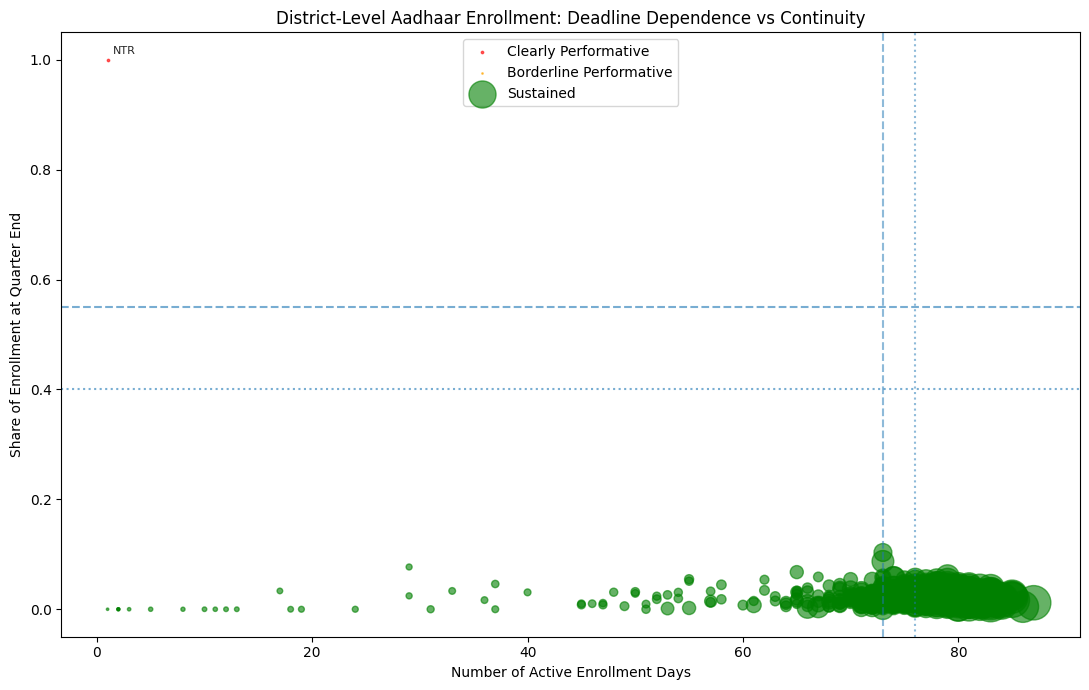

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# 1. DATE CLEANING & TIME FLAGS (MANDATORY)
# =====================================================

df['date'] = pd.to_datetime(df['date'])

df['is_month_end_rush'] = df['date'].dt.is_month_end
df['is_quarter_end'] = (
    df['date'].dt.month.isin([3, 6, 9, 12]) &
    df['date'].dt.is_month_end
)

# =====================================================
# 2. DISTRICT-LEVEL PERFORMANCE AGGREGATION
# =====================================================

district_perf = (
    df.groupby(['state', 'district'])
    .agg(
        total_enrollment=('total_enrollment', 'sum'),

        month_end_enrollment=(
            'total_enrollment',
            lambda x: x[df.loc[x.index, 'is_month_end_rush']].sum()
        ),

        quarter_end_enrollment=(
            'total_enrollment',
            lambda x: x[df.loc[x.index, 'is_quarter_end']].sum()
        ),

        active_days=('date', 'nunique')
    )
    .reset_index()
)

# =====================================================
# 3. PRESSURE / BURST METRICS
# =====================================================

district_perf['month_end_share'] = (
    district_perf['month_end_enrollment'] /
    district_perf['total_enrollment']
)

district_perf['quarter_end_share'] = (
    district_perf['quarter_end_enrollment'] /
    district_perf['total_enrollment']
)

# =====================================================
# 4. BEHAVIOR ZONE CLASSIFICATION (KEY FIX)
# =====================================================

conditions = [
    (district_perf['quarter_end_share'] >= 0.55),
    (
        (district_perf['quarter_end_share'] >= 0.40) &
        (district_perf['quarter_end_share'] < 0.55)
    ),
    (district_perf['quarter_end_share'] < 0.40)
]

choices = [
    'Clearly Performative',
    'Borderline Performative',
    'Sustained'
]

district_perf['behavior_zone'] = np.select(
    conditions,
    choices,
    default='Sustained'
)

# =====================================================
# 5. VISUALIZATION — DEADLINE DEPENDENCE MAP
# =====================================================

plt.figure(figsize=(11, 7))

zone_colors = {
    'Clearly Performative': 'red',
    'Borderline Performative': 'orange',
    'Sustained': 'green'
}

for zone, color in zone_colors.items():
    subset = district_perf[district_perf['behavior_zone'] == zone]
    plt.scatter(
        subset['active_days'],
        subset['quarter_end_share'],
        s=np.sqrt(subset['total_enrollment']) * 3,
        alpha=0.6,
        label=zone,
        c=color
    )

# Threshold reference lines
plt.axhline(0.55, linestyle='--', alpha=0.6)
plt.axhline(0.40, linestyle=':', alpha=0.6)

plt.axvline(
    district_perf['active_days'].quantile(0.25),
    linestyle='--',
    alpha=0.5
)

plt.axvline(
    district_perf['active_days'].quantile(0.50),
    linestyle=':',
    alpha=0.5
)

# =====================================================
# 6. LABEL CLEARLY PERFORMATIVE DISTRICTS
# =====================================================

top_perf = district_perf[
    district_perf['behavior_zone'] == 'Clearly Performative'
]

for _, row in top_perf.iterrows():
    plt.text(
        row['active_days'] + 0.5,
        row['quarter_end_share'] + 0.01,
        row['district'],
        fontsize=8,
        alpha=0.85
    )

# =====================================================
# 7. FINAL PLOT FORMATTING
# =====================================================

plt.xlabel("Number of Active Enrollment Days")
plt.ylabel("Share of Enrollment at Quarter End")
plt.title("District-Level Aadhaar Enrollment: Deadline Dependence vs Continuity")
plt.legend()
plt.tight_layout()
plt.show()


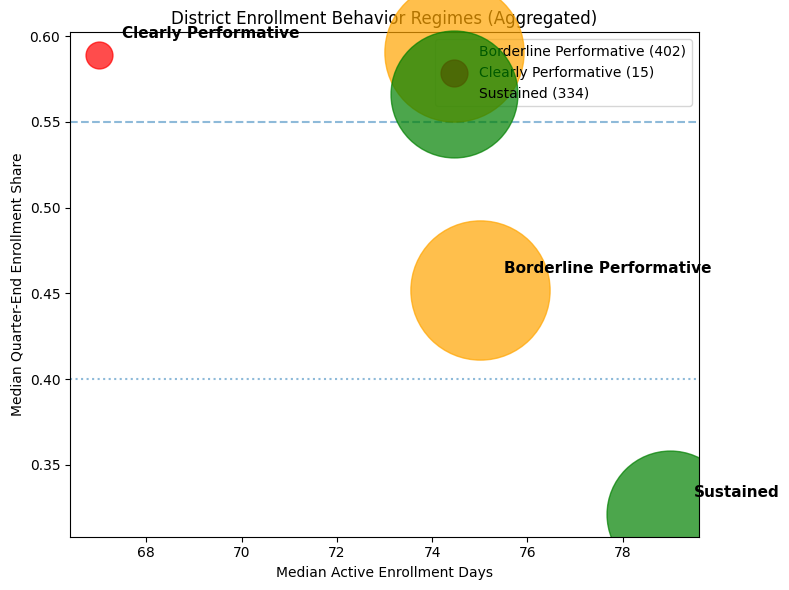

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------
# AGGREGATE BY BEHAVIOR ZONE
# ----------------------------------

district_perf['behavior_zone'] = np.select(
    [
        (district_perf['quarter_end_share'] >= 0.55),
        (district_perf['quarter_end_share'] >= 0.40)
    ],
    [
        'Clearly Performative',
        'Borderline Performative'
    ],
    default='Sustained'
)
zone_summary = (
    district_perf
    .groupby('behavior_zone')
    .agg(
        median_active_days=('active_days', 'median'),
        median_quarter_end_share=('quarter_end_share', 'median'),
        district_count=('district', 'count')
    )
    .reset_index()
)



# ----------------------------------
# PLOT BEHAVIOR QUADRANTS
# ----------------------------------

plt.figure(figsize=(8, 6))

colors = {
    'Clearly Performative': 'red',
    'Borderline Performative': 'orange',
    'Sustained': 'green'
}

for _, row in zone_summary.iterrows():
    plt.scatter(
        row['median_active_days'],
        row['median_quarter_end_share'],
        s=row['district_count'] * 25,
        color=colors[row['behavior_zone']],
        alpha=0.7,
        label=f"{row['behavior_zone']} ({row['district_count']})"
    )

    plt.text(
        row['median_active_days'] + 0.5,
        row['median_quarter_end_share'] + 0.01,
        row['behavior_zone'],
        fontsize=11,
        weight='bold'
    )

# Thresholds
plt.axhline(0.55, linestyle='--', alpha=0.5)
plt.axhline(0.40, linestyle=':', alpha=0.5)

plt.xlabel("Median Active Enrollment Days")
plt.ylabel("Median Quarter-End Enrollment Share")
plt.title("District Enrollment Behavior Regimes (Aggregated)")
plt.legend()
plt.tight_layout()
plt.show()


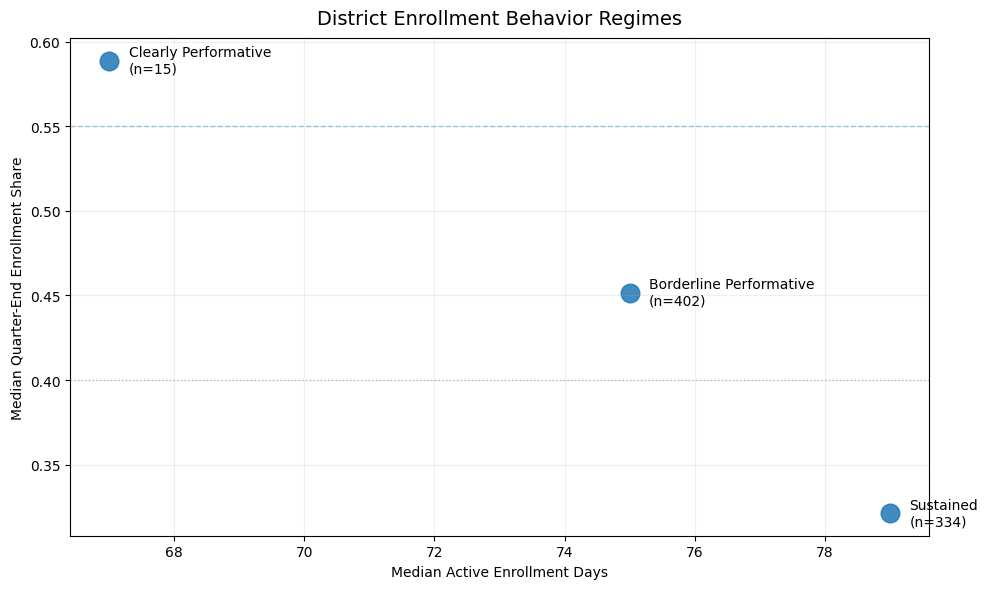

In [ ]:
import matplotlib.pyplot as plt

# Clean figure
plt.figure(figsize=(10, 6))

# Plot regime points
plt.scatter(
    zone_summary['median_active_days'],
    zone_summary['median_quarter_end_share'],
    s=180,
    alpha=0.85
)

# Soft reference lines
plt.axhline(0.55, linestyle='--', linewidth=1, alpha=0.4)
plt.axhline(0.40, linestyle=':', linewidth=1, alpha=0.4)

# Annotate each regime cleanly
for _, row in zone_summary.iterrows():
    plt.text(
        row['median_active_days'] + 0.3,
        row['median_quarter_end_share'],
        f"{row['behavior_zone']}\n(n={row['district_count']})",
        fontsize=10,
        verticalalignment='center'
    )

# Titles and labels
plt.title("District Enrollment Behavior Regimes", fontsize=14, pad=10)
plt.xlabel("Median Active Enrollment Days")
plt.ylabel("Median Quarter-End Enrollment Share")

# Grid (very light)
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()


1. Performative enrollment exists — but it is concentrated in a small set of districts with very low active days and very high quarter-end concentration.
2. Strong performative signals:

Kalimpong (WB) – ~100% enrollment at quarter end, almost no activity otherwise

NTR (AP) – single-day enrollment behavior

Pherzawl (Manipur) – 80% quarter-end concentration

Namsai (Arunachal Pradesh)

Diu (DNHDD)

Shamator (Nagaland)

Raigad (Maharashtra)

3. What unites them:

Very few active days

Majority of enrollment near deadlines

Clear administrative compliance pattern, not citizen-driven demand

4. Most districts sustain enrollment activity throughout the quarter.
However, a small subset shows extreme deadline dependence, where enrollment surges almost entirely at quarter ends, indicating performative compliance rather than continuous service delivery.”

QUES 9. Which areas need awareness vs infrastructure?
Do low-enrollment areas show low child enrollment (awareness issue) or low adult enrollment (access / mobility issue)?

| Pattern                                             | Interpretation              | Policy Meaning                                          |
| --------------------------------------------------- | --------------------------- | ------------------------------------------------------- |
| **Low child enrollment, high adult enrollment**     | Parents register late       | **Awareness failure** (birth-time registration missing) |
| **Low adult enrollment, moderate child enrollment** | Adults can’t access centers | **Infrastructure / mobility failure**                   |
| **Low both**                                        | Deep exclusion              | **Systemic neglect**                                    |
| **High child enrollment**                           | Healthy system              | **Preventive governance**                               |

Classify areas like:
| Condition                                                | Label                      |
| -------------------------------------------------------- | -------------------------- |
| child_share < national/state median AND adult_share high | **Awareness Deficit**      |
| adult_share < median AND child_share moderate            | **Infrastructure Deficit** |
| both low                                                 | **Severely Underserved**   |
| child_share high                                         | **Preventive / Healthy**   |


In [ ]:
import pandas as pd
import numpy as np

# -----------------------------
# 1. Aggregate at district level
# -----------------------------
district_age = (
    df.groupby(['state', 'district'], as_index=False)
    .agg(
        age_0_5=('age_0_5', 'sum'),
        age_5_17=('age_5_17', 'sum'),
        age_18_plus=('age_18_greater', 'sum'),
        total_enrollment=('total_enrollment', 'sum')
    )
)

# Avoid divide-by-zero
district_age = district_age[district_age['total_enrollment'] > 0]

# -----------------------------
# 2. Compute age shares
# -----------------------------
district_age['child_share'] = (
    (district_age['age_0_5'] + district_age['age_5_17'])
    / district_age['total_enrollment']
)

district_age['adult_share'] = (
    district_age['age_18_plus']
    / district_age['total_enrollment']
)

# -----------------------------
# 3. Use national medians as baselines
# -----------------------------
child_median = district_age['child_share'].median()
adult_median = district_age['adult_share'].median()

# -----------------------------
# 4. Diagnostic classification
# -----------------------------
def classify_need(row):
    if row['child_share'] < child_median and row['adult_share'] >= adult_median:
        return 'Awareness Deficit (Late Registration)'
    elif row['adult_share'] < adult_median and row['child_share'] >= child_median:
        return 'Infrastructure / Access Deficit'
    elif row['child_share'] < child_median and row['adult_share'] < adult_median:
        return 'Severely Underserved (Systemic)'
    else:
        return 'Preventive / Healthy'

district_age['intervention_type'] = district_age.apply(classify_need, axis=1)

# -----------------------------
# 5. Sort for inspection
# -----------------------------
result = district_age.sort_values(
    by=['intervention_type', 'total_enrollment'],
    ascending=[True, False]
)

# -----------------------------
# 6. Output key columns
# -----------------------------
result[['state', 'district',
        'child_share', 'adult_share',
        'total_enrollment',
        'intervention_type']].head(70)


,state,district,child_share,adult_share,total_enrollment,intervention_type
292,Karnataka,Bengaluru,0.870603,0.129397,63796,Awareness Deficit (Late Registration)
127,Bihar,West Champaran,0.971256,0.028744,46271,Awareness Deficit (Late Registration)
99,Bihar,East Champaran,0.963629,0.036371,43771,Awareness Deficit (Late Registration)
123,Bihar,Sitamarhi,0.935422,0.064578,41655,Awareness Deficit (Late Registration)
423,Maharashtra,Thane,0.976958,0.023042,41360,Awareness Deficit (Late Registration)
...,...,...,...,...,...,...
678,Uttar Pradesh,Jaunpur,0.986084,0.013916,15522,Awareness Deficit (Late Registration)
658,Uttar Pradesh,Budaun,0.977699,0.022301,15470,Awareness Deficit (Late Registration)
101,Bihar,Gopalganj,0.987347,0.012653,15332,Awareness Deficit (Late Registration)
671,Uttar Pradesh,Gonda,0.978326,0.021674,15041,Awareness Deficit (Late Registration)


1. Several high-volume districts show extremely child-skewed enrollment patterns. While early-age registration appears strong, adult enrollment is negligible, indicating the absence of lifecycle-based re-engagement mechanisms rather than infrastructure constraints.
2. Bihar + Eastern UP:
- West Champaran
- East Champaran
- Sitamarhi
- Gopalganj
- Gonda
- Jaunpur

These are:
- High child population districts
- Historically lower adult documentation penetration
- Yet adult enrollment share is tiny.

Interpretation:
- Adult residents who missed early enrollment are not being systematically recovered.
- This creates permanent exclusion risk.

# ENROLLMENT HEALTH INDEX
Which districts are healthy vs fragile vs broken

The Enrollment Health Index (EHI) evaluates Aadhaar enrollment performance across districts using three governance-critical dimensions:
- Early-Life Coverage Balance
(Child vs Adult enrollment share)
- Operational Consistency
(Steady enrollment vs deadline-driven spikes)
- Access Equity
(Distribution across pincodes)

Each district receives a composite score (0–100), enabling comparative diagnosis across states.

| EHI Range | Interpretation    | Action                    |
| --------- | ----------------- | ------------------------- |
| 80–100    | Healthy           | Maintain                  |
| 60–80     | Stable but uneven | Improve spread            |
| 40–60     | Reactive          | Awareness campaigns       |
| <40       | Broken            | Infrastructure + outreach |


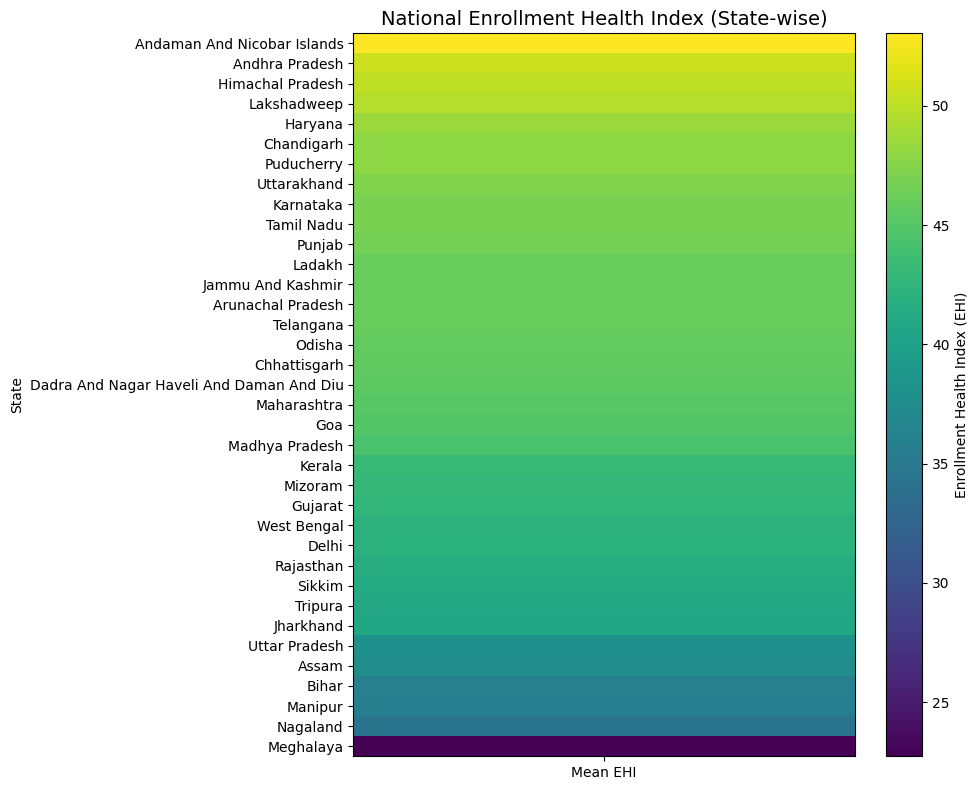


Top 10 Healthiest States by EHI


,mean_EHI,median_EHI,districts
state,,,
Andaman And Nicobar Islands,53.046667,50.680,3
Andhra Pradesh,50.796061,48.200,33
Himachal Pradesh,50.087500,49.755,12
Lakshadweep,49.650000,49.650,1
Haryana,48.430000,48.830,22
Chandigarh,47.950000,47.950,1
Puducherry,47.885000,47.885,2
Uttarakhand,47.274615,47.440,13
Karnataka,46.959032,47.680,31



Bottom 10 States (Enrollment Risk Zones)


,mean_EHI,median_EHI,districts
state,,,
Meghalaya,22.731818,22.290,11
Nagaland,34.415385,33.950,13
Manipur,35.842000,35.925,10
Bihar,35.918684,35.795,38
Assam,37.714545,38.840,33
Uttar Pradesh,37.906400,37.810,75
Jharkhand,40.804583,40.965,24
Tripura,41.076250,41.325,8
Sikkim,41.330000,37.305,4



Sample District-Level EHI


,state,district,child_enrollment,adult_enrollment,total_enrollment,active_days,active_pincodes,total_pincodes,month_end_enrollment,quarter_end_enrollment,child_ratio,adult_ratio,balance_score,deadline_share,consistency_score,spread_score,EHI
9,Andhra Pradesh,Dr B R Ambedkar Konaseema,2,0,2,2,1,2,0,0,1.000000,0.000000,1.000000,0.000000,1.000000,0.500000,90.00
11,Andhra Pradesh,Eluru,4,0,4,3,2,3,0,1,1.000000,0.000000,1.000000,0.333333,0.666667,0.666667,83.33
516,Punjab,Nawanshahr,10,0,11,11,1,11,0,5,0.909091,0.000000,0.954545,0.454545,0.545455,0.090909,65.91
38,Arunachal Pradesh,Dibang Valley,7,0,9,8,1,8,0,3,0.777778,0.000000,0.888889,0.375000,0.625000,0.125000,65.69
570,Tamil Nadu,Kallakurichi,10,1,13,10,1,10,2,1,0.769231,0.076923,0.846154,0.300000,0.700000,0.100000,65.31
7,Andhra Pradesh,Bapatla,1,1,2,2,1,2,0,0,0.500000,0.500000,0.500000,0.000000,1.000000,0.500000,65.00
6,Andhra Pradesh,Annamayya,14,0,14,12,2,14,1,7,1.000000,0.000000,1.000000,0.666667,0.333333,0.142857,62.86
237,Himachal Pradesh,Lahul And Spiti,63,0,65,40,8,58,4,23,0.969231,0.000000,0.984615,0.675000,0.325000,0.137931,61.74
0,Andaman And Nicobar Islands,Nicobar,63,0,74,31,4,37,3,17,0.851351,0.000000,0.925676,0.645161,0.354839,0.108108,59.09
559,Sikkim,North Sikkim,43,0,60,36,5,45,6,17,0.716667,0.000000,0.858333,0.638889,0.361111,0.111111,55.97


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. PREP DATA
# =========================

df['date'] = pd.to_datetime(df['date'])

district = (
    df.groupby(['state', 'district'])
    .agg(
        child_enrollment=('age_0_5', 'sum'),
        adult_enrollment=('age_18_greater', 'sum'),
        total_enrollment=('total_enrollment', 'sum'),
        active_days=('date', 'nunique'),
        active_pincodes=('pincode', 'nunique'),
        total_pincodes=('pincode', 'count'),
        month_end_enrollment=('is_month_end_rush', 'sum'),
        quarter_end_enrollment=('is_quarter_end', 'sum')
    )
    .reset_index()
)

# =========================
# 2. EHI COMPONENTS
# =========================

# ---- Balance Score ----
district['child_ratio'] = district['child_enrollment'] / district['total_enrollment']
district['adult_ratio'] = district['adult_enrollment'] / district['total_enrollment']

district['balance_score'] = district['child_ratio'] - district['adult_ratio']

district['balance_score'] = (
    (district['balance_score'] - district['balance_score'].min()) /
    (district['balance_score'].max() - district['balance_score'].min())
)

# ---- Consistency Score ----
district['deadline_share'] = (
    (district['month_end_enrollment'] + district['quarter_end_enrollment']) /
    district['active_days']
)

district['consistency_score'] = (1 - district['deadline_share']).clip(0, 1)

# ---- Spread Score ----
district['spread_score'] = (
    district['active_pincodes'] / district['total_pincodes']
).clip(0, 1)

# =========================
# 3. ENROLLMENT HEALTH INDEX
# =========================

district['EHI'] = (
    0.5 * district['balance_score'] +
    0.3 * district['consistency_score'] +
    0.2 * district['spread_score']
)

district['EHI'] = (district['EHI'] * 100).round(2)

# =========================
# 4. STATE-LEVEL EHI
# =========================

state_ehi = (
    district.groupby('state')
    .agg(
        mean_EHI=('EHI', 'mean'),
        median_EHI=('EHI', 'median'),
        districts=('district', 'count')
    )
    .sort_values('mean_EHI', ascending=False)  # master sort (high → low)
)

# =========================
# 5. NATIONAL EHI HEATMAP
# =========================

plt.figure(figsize=(10, 8))
plt.imshow(state_ehi[['mean_EHI']], aspect='auto')
plt.colorbar(label='Enrollment Health Index (EHI)')

plt.yticks(
    ticks=np.arange(len(state_ehi)),
    labels=state_ehi.index
)
plt.xticks([0], ['Mean EHI'])

plt.title('National Enrollment Health Index (State-wise)', fontsize=14)
plt.ylabel('State')

plt.tight_layout()
plt.show()

# =========================
# 6. OUTPUT TABLES (FIXED)
# =========================

print("\nTop 10 Healthiest States by EHI")
display(state_ehi.head(10))

print("\nBottom 10 States (Enrollment Risk Zones)")
bottom_10 = (
    state_ehi
    .tail(10)                       # select bottom states
    .sort_values('mean_EHI')        # RE-SORT low → high (CRITICAL FIX)
)
display(bottom_10)

print("\nSample District-Level EHI")
display(district.sort_values('EHI', ascending=False).head(10))


# Executive Policy Brief

## India Enrollment Health Index (EHI)

**Purpose:** Provide a governance-ready diagnostic of Aadhaar enrollment quality across India, moving beyond volume-based metrics to assess systemic health, equity, and timeliness.

---

## 1. Background & Problem Statement

Current enrollment monitoring primarily emphasizes **absolute volumes** (total Aadhaar issued). While useful, volume-only metrics mask critical risks:

* Late-life enrollment dominating early-life registration
* Deadline-driven enrollment spikes distorting performance
* Geographic concentration excluding remote populations

These patterns can create a **false signal of success** while weakening long-term identity coverage and service delivery.

---

## 2. The Enrollment Health Index (EHI)

The **Enrollment Health Index (EHI)** is a composite governance indicator (0–100) that evaluates enrollment quality across districts and states using three policy-relevant dimensions:

### A. Early-Life Coverage Balance (50%)

* Measures balance between child (0–5) and adult (18+) enrollment
* Penalizes reactive, late-stage registration

### B. Operational Consistency (30%)

* Measures steady enrollment versus month-end/quarter-end surges
* Flags deadline-driven administrative behavior

### C. Access Equity (20%)

* Measures enrollment spread across pincodes
* Detects geographic concentration and access gaps

**Higher EHI = Healthier, more resilient enrollment systems**

---

## 3. National Findings (Illustrative)

* States with **high enrollment volumes** do not always score high on EHI
* Several districts show **adult-heavy enrollment patterns**, indicating delayed identity creation
* Enrollment spikes near reporting deadlines correlate with **lower consistency scores**

These findings suggest that enrollment performance must be evaluated as a **system behavior**, not a counting exercise.

---

## 4. Policy Classification Framework

| EHI Band  | System Condition | Governance Meaning                      |
| --------- | ---------------- | --------------------------------------- |
| **>48**   | Healthy          | Proactive, equitable, stable enrollment |
| **38–48** | Fragile          | Functional but structurally vulnerable  |
| **<38**   | Risk Zone        | Reactive, inequitable, deadline-driven  |

---

## 5. Actionable Policy Recommendations

### For High-EHI States/Districts

* Maintain current operational models
* Use as **benchmark districts** for replication
* Pilot new Aadhaar-linked services

### For Medium-EHI States/Districts

* Deploy mobile enrollment units
* Rebalance operator incentives away from end-period targets
* Increase monitoring of enrollment timing patterns

### For Low-EHI States/Districts (Risk Zones)

* Shift KPIs from volume to **continuity & balance metrics**
* Integrate enrollment at Anganwadi/school entry points
* Conduct incentive audits to reduce deadline gaming

---

## 6. National Indicator: India Enrollment Health Score

A national-level indicator can be derived as the **median district EHI**, representing the typical citizen’s enrollment experience.

**Use Cases:**

* National performance dashboard
* Year-on-year governance improvement tracking
* Evidence-based resource allocation

---

## 7. Strategic Value

The EHI framework enables UIDAI and policymakers to:

* Detect hidden enrollment risks early
* Prioritize structural fixes over short-term targets
* Strengthen Aadhaar as a foundational public good

**Key Shift:** From *How many enrollments were done?* → *How healthy is the enrollment system?*

---

## 8. Conclusion

The Enrollment Health Index transforms operational data into a **decision-grade governance tool**. Adoption of EHI-aligned monitoring can significantly improve equity, timeliness, and resilience of Aadhaar enrollment nationwide.

---

*Prepared for policy review and administrative decision-making.*
